# CIS 5450 Final Project- Spotify Song Genre Clustering

**By: Trey Elder, Nicky Desai, and Alon Jacoby**

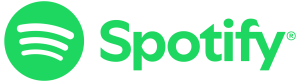

# Part 1: Introduction

MarketingCharts.com reports that global on-demand audio streaming continued its rapid rise in 2025, increasing 14% to 14.8 trillion total streams. While the growing number of subscribers contributes to this trend, an even more important factor is deeper listener engagement. Average listening hours per user have steadily climbed, showing that people are spending more time on platforms like Spotify than ever before.

One likely reason for this increased engagement is the improvement of personalized recommendation systems. Spotify, for example, has become highly effective at identifying users’ niche genre interests and curating playlists based on detailed listening patterns. However, despite the strength of these internal recommendation models, Spotify’s API does not provide song-level genre labels. Only artist-level genres are available—an unreliable substitute, since many artists shift styles across albums and even across individual tracks.

To better understand song-level genre structure, our project uses a large Spotify dataset containing crawled genre labels from an unknown third-party source (not from Spotify itself). These labels serve as a rough reference point, but our goal is not to treat them as ground truth. Instead, we aim to rediscover meaningful genre groupings by clustering songs using their acoustic and musical features (e.g, danceability, loudness, speechiness, tempo).

### Project Objectives

1. Use crawled genre labels as a comparative benchmark, not a definitive truth.

2. Apply multiple unsupervised learning techniques to cluster songs:
  
  - k-Means
  - DBSCAN
  - Agglomerative Hierarchical Clustering
    - (including dendrogram analysis and optimal cutoff selection)

3. Evaluate model performance by comparing cluster assignments with the crawled labels:
  
  - Error rates
  - Cluster-to-label agreement
  - Additional statistical analyses to assess significance


# Part 2: Data Loading and Initial Inspection

We install KaggleHub to download the Spotify dataset directly into the Colab environment, eliminating the need to manually dowload the files to our local machine. KaggleHub stores the data in Colab's temporary cloud storage, making the workflow cleaner and easier without requiring local disk space.

In [ ]:
! pip install kagglehub
! pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.2 MB/s eta 0:00:00


In this step, we import all of the essential libraries used throughout the project — including those required for data preprocessing, exploratory data analysis (EDA), and model development.

In [ ]:
import kagglehub
import pandas as pd
import os
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.base import clone
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import seaborn as sns
import duckdb
import re

The code below downloads the Spotify dataset using KaggleHub, verifies the donloaded files, and loads the main CSV file (spotify_data.csv) into a pandas DataFrame, giving us immeadiate access to over one million tracks and their audio features.

In [ ]:
# Download dataset
path = kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")
print("Path to dataset files:", path)
print(os.listdir(path))  # just to confirm

# Read the CSV that actually exists
csv_path = os.path.join(path, "spotify_data.csv") #safely builds the file path regardless of the operating system
spotify_df = pd.read_csv(csv_path)


Using Colab cache for faster access to the 'spotify-1million-tracks' dataset.
Path to dataset files: /kaggle/input/spotify-1million-tracks
['spotify_data.csv']


## Part 2.1: Viewing the Dataset Shape

In [ ]:
#Shape of the dataset
spotify_df.shape

(1159764, 20)

## Part 2.2: Displaying the First Few Rows

In [ ]:
# Quick peek of the head of the dataset
spotify_df.head(10)

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4
5,5,Chris Smither,What They Say,24NvptbNKGs6sPy1Vh1O0v,48,2012,acoustic,0.566,0.570,2,-6.420,1,0.0329,0.6880,0.000002,0.0943,0.960,83.403,166240,4
6,6,Matt Wertz,Walking in a Winter Wonderland,0BP7hSvLAG3URGrEvNNbGM,48,2012,acoustic,0.575,0.606,9,-8.197,1,0.0300,0.0119,0.000000,0.0675,0.364,121.083,152307,4
7,7,Green River Ordinance,Dancing Shoes,3Y6BuzQCg9p4yH347Nn8OW,45,2012,acoustic,0.586,0.423,7,-7.459,1,0.0261,0.2520,0.000006,0.0976,0.318,138.133,232373,4
8,8,Jason Mraz,Living in the Moment,3ce7k1L4EkZppZPz1EJWTS,44,2012,acoustic,0.650,0.628,7,-7.160,1,0.0232,0.0483,0.000000,0.1190,0.700,84.141,235080,4
9,9,Boyce Avenue,Heaven,2EKxmYmUdAVXlaHCnnW13o,58,2012,acoustic,0.619,0.280,8,-10.238,0,0.0317,0.7300,0.000000,0.1030,0.292,129.948,250063,4


From the dataset’s shape, we see that it contains over one million rows, which is interesting given that the Kaggle title (“Spotify 1 Million Tracks”) suggests a smaller size. This discrepancy may indicate the presence of duplicate entries or additional tracks included in the scrape. The dataset also contains 20 columns, some of which (e.g., `track_id`) are unlikely to be useful for modeling or may be highly correlated with other variables. As a result, we will later reduce the feature set by removing irrelevant columns and checking for multicollinearity.


## Part 2.3: Inspecting Column Names and Meaning

After inspecting first few rows of the dataset, we quickly noticed a key issue: although the feature names (e.g., `energy`, `acousticness`, `liveness`) give a general sense of what they represent, many of them are not intuitive, and the Kaggle dataset provides little to no explanation of how these values are defined or measured. Without clear definitions, it becomes difficult to interpret the features correctly or understand their relationships.

To ensure accurate analysis, we obtained access to the official Spotify API documentation, which provides precise descriptions of each audio feature and how Spotify computes them. These definitions not only clarify the meaning of each variable, but they also highlight that several features capture overlapping musical qualities—for example, energy, loudness, and valence are often correlated. We will address these potential collinearities in detail during the EDA section.

Below, we include a curated set of the Spotify feature definitions most relevant to this project that are not easily interpretable:

In [ ]:

# List of (feature, short definition, range/notes)
rows = [
    ("acousticness",    "Confidence track is acoustic",                   "0.0–1.0 (higher = more acoustic)"),
    ("danceability",    "Suitability for dancing (tempo, rhythm, etc.)",  "0.0–1.0 (higher = more danceable)"),
    ("energy",          "Perceived intensity and activity",               "0.0–1.0 (higher = more energetic)"),
    ("instrumentalness","Likelihood track has no vocals",                 "> 0.5 ≈ likely instrumental"),
    ("key",             "Musical key as integer code",                    "0–11 (C–B), −1 = no key detected"),
    ("liveness",        "Probability of live performance",                "> 0.8 ≈ strong live likelihood"),
    ("loudness",        "Overall loudness in decibels",                   "≈ −60 to 0 dB"),
    ("mode",            "Modality of the track",                          "1 = major, 0 = minor"),
    ("speechiness",     "Presence of spoken words",                       ">0.66 speech, <0.33 mostly music"),
    ("tempo",           "Tempo in beats per minute",                      "BPM"),
    ("time_signature",  "Estimated meter (beats per bar)",               "3–7 (e.g., 4 → 4/4)"),
    ("valence",         "Musical positivity / happiness",                 "0.0–1.0 (higher = more positive)")
]

df_features = pd.DataFrame(rows, columns=["feature", "short_definition", "range_or_notes"])

# 1) Show as a nice HTML table in Colab
df_features

,feature,short_definition,range_or_notes
0,acousticness,Confidence track is acoustic,0.0–1.0 (higher = more acoustic)
1,danceability,"Suitability for dancing (tempo, rhythm, etc.)",0.0–1.0 (higher = more danceable)
2,energy,Perceived intensity and activity,0.0–1.0 (higher = more energetic)
3,instrumentalness,Likelihood track has no vocals,> 0.5 ≈ likely instrumental
4,key,Musical key as integer code,"0–11 (C–B), −1 = no key detected"
5,liveness,Probability of live performance,> 0.8 ≈ strong live likelihood
6,loudness,Overall loudness in decibels,≈ −60 to 0 dB
7,mode,Modality of the track,"1 = major, 0 = minor"
8,speechiness,Presence of spoken words,">0.66 speech, <0.33 mostly music"
9,tempo,Tempo in beats per minute,BPM


# Part 3: Minimal Data Cleaning (Pre-EDA Cleaning)

## Part 3.1: Removing Unwanted Index Columns

Let's first get rid of the `Unnamed:0` column as the dataset is already indexed the same way, so it is repititive to keep this column.

In [ ]:
spotify_df = spotify_df.drop(columns = ['Unnamed: 0'])

## Part 3.2: Inspecting Datatypes and Validating Correctness

Before conducting any exploratory data analysis or building models, it’s essential to verify that all feature datatypes are correctly formatted. If numeric values are stored as strings or objects, they can break visualizations, prevent accurate aggregations, and—most importantly—cause our unsupervised learning algorithms to fail. Since all of the clustering methods we plan to use (K-Means, DBSCAN, and Agglomerative Hierarchical Clustering) rely on distance calculations, they require a strictly numerical feature space. Ensuring the correct datatypes upfront allows these models to run properly and produce meaningful results.

In [ ]:
spotify_df.dtypes

,0
artist_name,object
track_name,object
track_id,object
popularity,int64
year,int64
genre,object
danceability,float64
energy,float64
key,int64
loudness,float64


After reviewing the spotify_df.dtypes output, all columns that should be numeric are already stored in the correct numeric formats (int64 or float64). These include:

**Audio features:** `danceability`, `energy`, `speechiness`, `acousticness`,
instrumentalness, `liveness`, `valence`, `tempo`, `loudness`

**Numeric metadata:** `popularity`, `year`, `key`, `mode`, `duration_ms`, `time_signature`

**The only non-numeric fields are:** `artist_name`, `track_name`, `track_id`, and `genre`, all of which are stored as strings. These fields represent descriptive information or identifiers, so retaining them as strings is appropriate at this stage of the workflow.

Although these columns may or may not be used directly in later modeling steps, there is no benefit to converting them now. Converting them prematurely (e.g., to categories or codes) could reduce flexibility for tasks such as grouping, merging, labeling, or encoding later on.

## Part 3.3: Performing Light Duplicate Checks

Since each song in the dataset is uniquely identified by its `track_id`, we treat this column as the dataset’s primary key. To ensure the integrity of the data, we check whether any duplicate track_id values exist.

In [ ]:
#Next step: Checking to see if there are any duplicate track_ids

print(spotify_df.duplicated(subset=['track_id']).sum())

0



If duplicates were present, it would indicate repeated rows referring to the same track, which we would need to remove. However, as shown below, there are no duplicate track IDs, so each row corresponds to a unique track.

# Part 4: Exploratory Data Analysis (EDA)

## Part 4.1: Summarizing Statistics

To summarize the numerical features in our dataset, we use describe() and apply a small formatting step to improve readability. Integer-typed columns are displayed as integers (except for statistics that are naturally floats, like the mean and standard deviation), while float-typed columns retain their decimal formatting. This gives us a clearer, more intuitive view of the data without altering any underlying values.

In [ ]:
desc = spotify_df.describe()

for col in desc.columns:
    if np.issubdtype(spotify_df[col].dtype, np.integer):
        desc[col] = desc[col].apply(
            lambda x: f"{x:.6f}" if x != int(x) else f"{int(x)}"
        )
    else:
        desc[col] = desc[col].apply(lambda x: f"{x:.6f}")

desc


,popularity,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1159764,1159764,1159764.000000,1159764.000000,1159764,1159764.000000,1159764,1159764.000000,1159764.000000,1159764.000000,1159764.000000,1159764.000000,1159764.000000,1159764,1159764
mean,18.383123,2011.955000,0.537438,0.639670,5.287778,-8.981353,0.634653,0.092815,0.321537,0.252349,0.223019,0.455564,121.377137,249561.781224,3.885879
std,15.885545,6.803901,0.184478,0.270501,3.555197,5.682215,0.481527,0.126841,0.354987,0.365073,0.201071,0.268519,29.779749,149426.164522,0.467697
min,0,2000,0.000000,0.000000,0,-58.100000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2073,0
25%,5,2006,0.413000,0.454000,2,-10.829000,0,0.037100,0.006400,0.000001,0.097900,0.226000,98.797000,181091,4
50%,15,2012,0.550000,0.694000,5,-7.450000,1,0.050700,0.147000,0.001760,0.134000,0.438000,121.931000,225744,4
75%,29,2018,0.677000,0.873000,8,-5.276000,1,0.089000,0.640000,0.614000,0.292000,0.674000,139.903000,286913.500000,4
max,100,2023,0.993000,1.000000,11,6.172000,1,0.971000,0.996000,1.000000,1.000000,1.000000,249.993000,6000495,5


**Summary of Numerical Feature Characteristics**:

The summary statistics of the numerical features reveal several important characteristics of the dataset:

1. **No missing values**  
   Every numerical column contains the full **1,159,764 observations**, confirming that there are no missing values in the features we plan to use for analysis and modeling.

2. **Wide temporal coverage**  
   The `year` variable ranges from **2000 to 2023**, with a **median of 2012**, indicating that the dataset is well-distributed across time and captures more than two decades of music.

3. **Most audio features follow a standardized 0–1 scale**  
   Core audio attributes—including `danceability`, `energy`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, and `valence`—are all bounded between 0 and 1.

   - **Several of these features are heavily skewed toward 0.**  
     Specifically, `speechiness`, `acousticness`, `instrumentalness`, and `liveness` all have median values very close to the lower bound.  
     Examples:  
       - `speechiness`: median = **0.0507**  
       - `acousticness`: median = **0.1470**  
       - `instrumentalness`: median = **0.00176**  
       - `liveness`: median = **0.1340**  
     These low medians suggest that highly acoustic, instrumental, or speech-heavy tracks are relatively uncommon.

   - **These same features have noticeably higher means than medians**, indicating positive skew (a long tail toward higher values).  
     For example:  
       - `acousticness`: mean = **0.3215** vs. median = **0.1470**  
       - `instrumentalness`: mean = **0.2523** vs. median = **0.00176**  
     This confirms that most songs cluster near 0, with a smaller subset stretching into higher ranges.

   - **`danceability`, `energy`, and `valence` are more centered around midrange values (~0.5).**  
     Their means and medians lie closer together, suggesting more balanced and less skewed distributions.  
     Examples:  
       - `danceability`: mean = **0.5374**, median = **0.5500**  
       - `energy`: mean = **0.6397**, median = **0.6940**  
       - `valence`: mean = **0.4556**, median = **0.4380**  
     These patterns indicate that the dataset contains a diverse mix of energetic, rhythmic, and emotionally varied tracks.

   - **High variability in certain audio features**  
     `speechiness` and `acousticness` have relatively high standard deviation values of **0.354987** and **0.365073**, indicating wide spread across the 0–1 range.  
     This suggests strong diversity in speech content and acoustic characteristics, which is beneficial for distinguishing different song types during modeling.

4. **Additional notable characteristics from the descriptive table**

   - **`loudness` ranges widely, with a minimum value of –58.1 dB.**  
     This extreme minimum is likely an outlier, but overall the `loudness` feature spans a broad dynamic range—from very quiet tracks to those mixed near the digital loudness ceiling (0 dB). This variation reflects strong genre diversity.

   - **`tempo` covers a broad musical spectrum.**  
     `tempo` values range from very slow tracks (~50 BPM) to extremely fast ones (>200 BPM), indicating that the dataset includes everything from ballads to high-energy electronic music. Such variability enhances the feature’s usefulness for identifying rhythmic differences between genres.

   - **`duration_ms` has high variability.**  
     The data include very short tracks (skits, interludes) and longer tracks (extended mixes, instrumentals), reflecting meaningful diversity in song structure and format.

   - **`key` is uniformly distributed.**  
     Musical key values (0–11) appear with roughly equal frequency, suggesting that no particular pitch center dominates the dataset—useful for avoiding tonal bias.

   - **`mode` is almost balanced between major (1) and minor (0).**  
     This near-even split indicates a healthy representation of both brighter, major-key tracks and darker, minor-key compositions.

   - **`time_signature` is dominated by 4/4.**  
     While this is expected in Western popular music, it also means this feature has low variability and may contribute less to downstream modeling.


Now we will explore descriptive information about the non-numeric features in the dataset. This provides a quick overview of how many **unique** values each column contains, as well as the most frequently occurring entry **top** and its frequency **freq**

In [ ]:
spotify_df.describe(include=['object'])


,artist_name,track_name,track_id,genre
count,1159749,1159763,1159764,1159764
unique,64158,882360,1159764,82
top,Traditional,Intro,4oMiOwhDZEdBuzAfhzRHbi,black-metal
freq,4058,466,1,21852


**Summary of Non-Numerical Feature Characteristics:**

The summary statistics of the non-numerical features reveal several important characteristics of the dataset:

1. **Missing values are present**  
   `artist_name` and `track_name` both contain a small number of missing values (15 and 1 entries, respectively). In contrast, `track_id` and `genre` contain **no null values**. Given the dataset size of **1,159,764 rows**, this missingness is minimal and does not pose issues for analysis.

2. **`track_id` behaves as a primary key**  
   The total count and number of unique `track_id` values both equal **1,159,764**, confirming that each row corresponds to a unique track identifier. This validates `track_id` as a proper primary key for the dataset.

3. **Artists tend to have many tracks represented**  
   There are **64,158 unique artists** in the dataset. The ratio of total (non-null) `artist_name` entries to unique artists is approximately **18.07**, meaning that on average, each artist appears with **about 18 tracks**. This distribution is skewed by heavily represented artists such as `"Traditional"`, which appears **4,058 times**, indicating that some label categories represent large collections of public-domain or traditional works.

4. **Large number of repeated track names**  
   There are **882,360 unique `track_name` values** out of **1,159,763 total entries**, meaning **277,403 tracks share a name**.  
   This can occur for two reasons:  
   - Different artists may legitimately release different songs with the same `track_name`, and  
   - A single song may appear in multiple versions (e.g., remastered, acoustic, live, extended, or remixed editions).  
   This confirms that `track_name` alone cannot be used to uniquely identify a song.

5. **Wide variety of genre labels**  
   The dataset includes **82 distinct `genre` labels**, with `black-metal` being the most frequent (21,852 tracks). Since `genre` labels will later be used as a reference for evaluating or guiding clustering, we may consider consolidating related genres into broader categories to create clearer and more interpretable clusters.


## Part 4.2: Distribution Plots

In the next step of our EDA, we visualize the distributions of our numerical features to better understand how each variable is shaped.
This is an important step because it helps us see:

- how values are spread across the dataset,
- whether features are skewed or balanced,
- and whether any transformations or feature engineering (e.g., binning, scaling, or normalizing) may be useful later.

Below, we plot kernel density estimates for all numerical **continuous** features used in modeling (we exclude `key` and `time_signature` because they are discrete numeric variables).


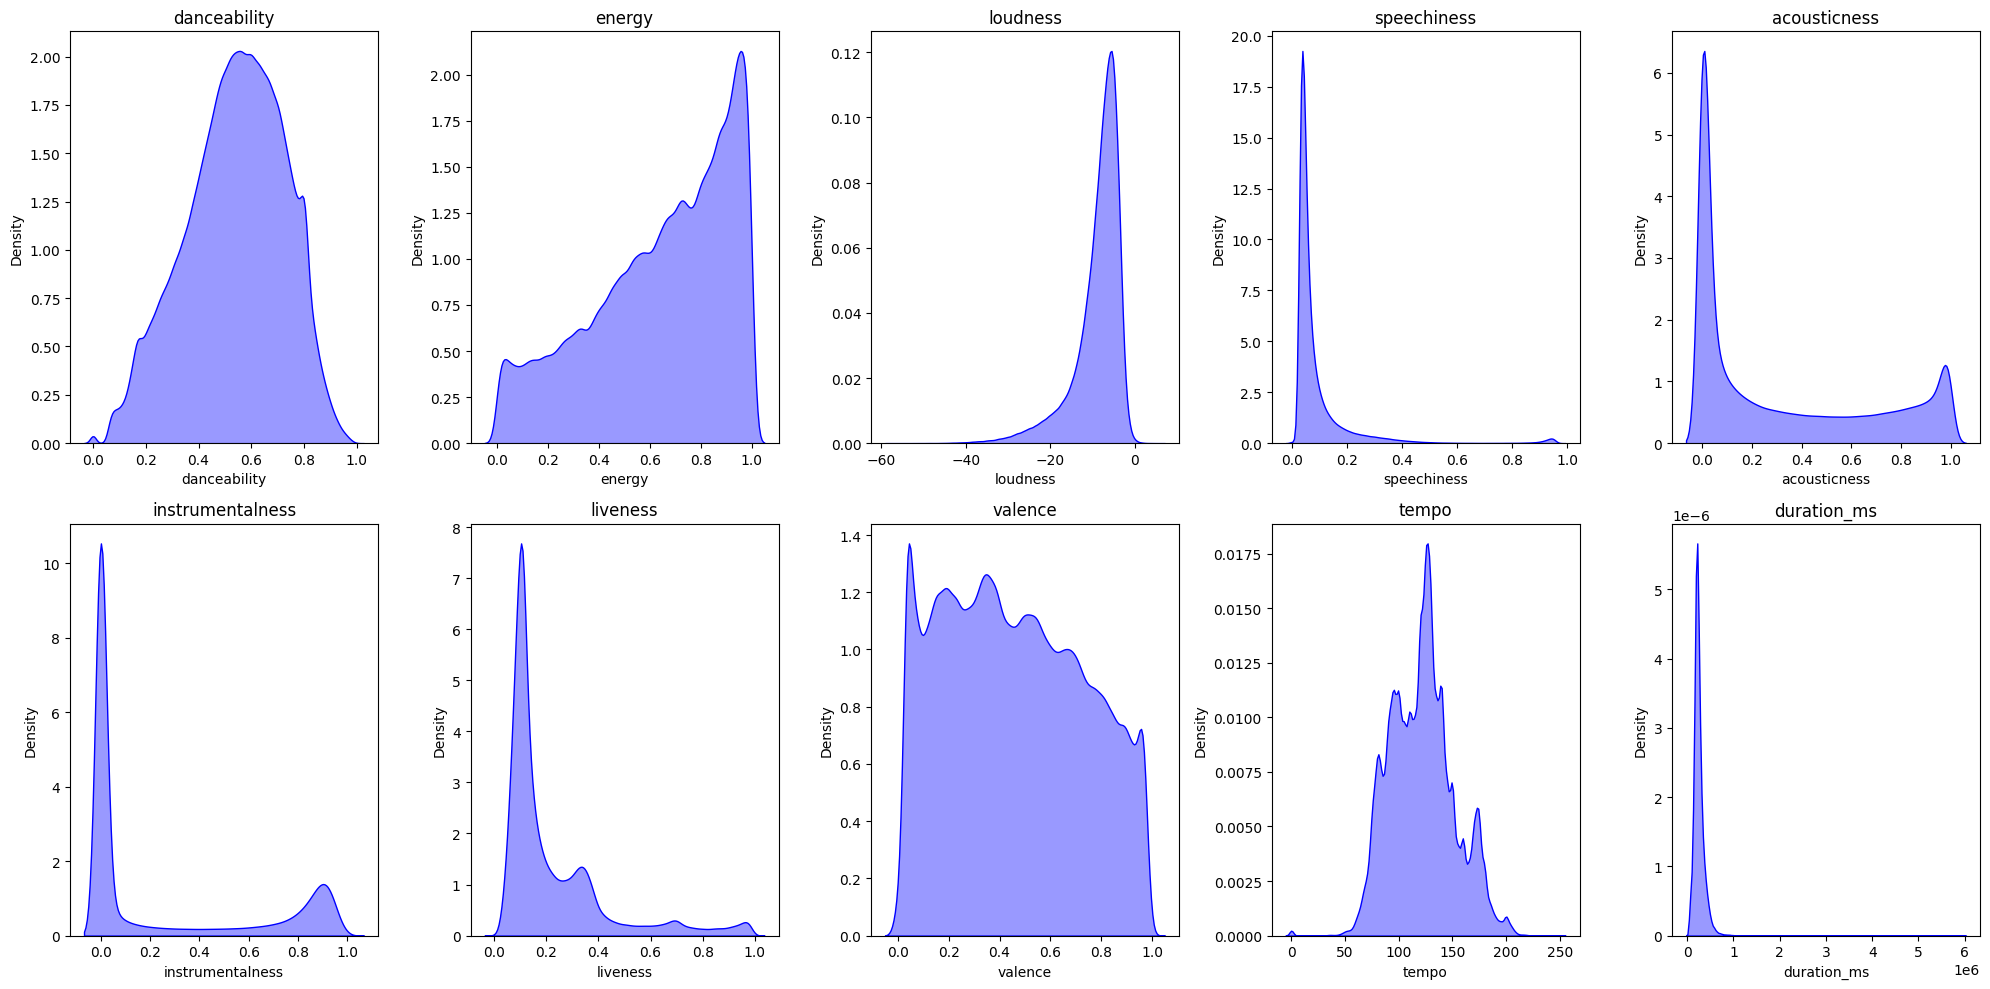

In [ ]:
numerical_columns = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms"]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for i, feature in enumerate(numerical_columns):
  sns.kdeplot(data = spotify_df, x = feature, fill = True, ax = axes[i], alpha = 0.4, color = "blue")
  axes[i].set_title(feature)
plt.tight_layout()
plt.show()

**Key Observations from the Density Plots**

The density plots of the numerical audio features reveal several meaningful patterns about how these variables behave across the dataset:

1. **Clustered (quasi-binary) distributions**  
   `instrumentalness`, `acousticness`, and `speechiness` all show distinct clusters**:  
   - a very large concentration of tracks near **0**, and  
   - a smaller but noticeable concentration near **1**.  

   This explains why the summary statistics showed **very low medians**, **much higher means**, and **relatively large standard deviations** for these features.

   Spotify's definitions confirm that these variables behave like **hidden categorical indicators**:
   - `instrumentalness`: values above **0.5** indicate instrumental tracks, with increasing confidence as values approach **1**.  
   - `speechiness`:  
     - 1-0.66 → predominantly spoken-word content  
     - 0.33–0.66 → mixed speech and music (e.g., rap)  
     - < 0.33 → primarily musical  
   - `acousticness`: although not tied to explicit thresholds, its distribution clearly forms two clumps, suggesting a quasi-binary pattern (high vs. low acoustic presence).

   These behaviors imply that the features act like **soft binary variables** rather than continuous measures evenly distributed across 0–1.

2. **Approximately bell-shaped (near-normal) features**  
   `tempo`, `valence`, and `danceability` exhibit smoother, more continuous density curves.  
   - `danceability` is the smoothest and closest to a normal-like shape.  
   - `tempo` has minor peaks but remains broadly unimodal.  
   - `valence` is mostly bell-shaped with some skew (discussed below).  
   These patterns suggest more natural variation without strong mode separation.

3. **Right-skewed features**  
   Several features show long right tails:
   - `valence` (slightly right-skewed)  
   - `liveness` (right-skewed)  
   - `duration_ms` (**heavily** right-skewed)  

   These distributions indicate that:
   - most tracks are low in liveness (few live performances),  
   - most tracks cluster around shorter durations, with a long tail of extended or ambient tracks.

4. **Left-skewed features**  
   - `energy`  
   - `loudness`  

   Both features skew left, meaning the majority of tracks are relatively **energetic** and **loud**, with fewer quiet or low-energy tracks.  
   This aligns well with common characteristics of modern popular and electronic music.

Overall, these density plots reinforce the strong diversity of the dataset while highlighting several features that behave more like **categorical indicators** than continuous variables. This will be important to consider in later preprocessing and modeling steps.



Now we will visualize the distributions of the discrete numerical variables. Because these features take on a limited set of integer values, bar plots are the most appropriate choice for showing how frequently each category appears in the dataset.

/tmp/ipython-input-2832014477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_df, x=var, palette="husl")


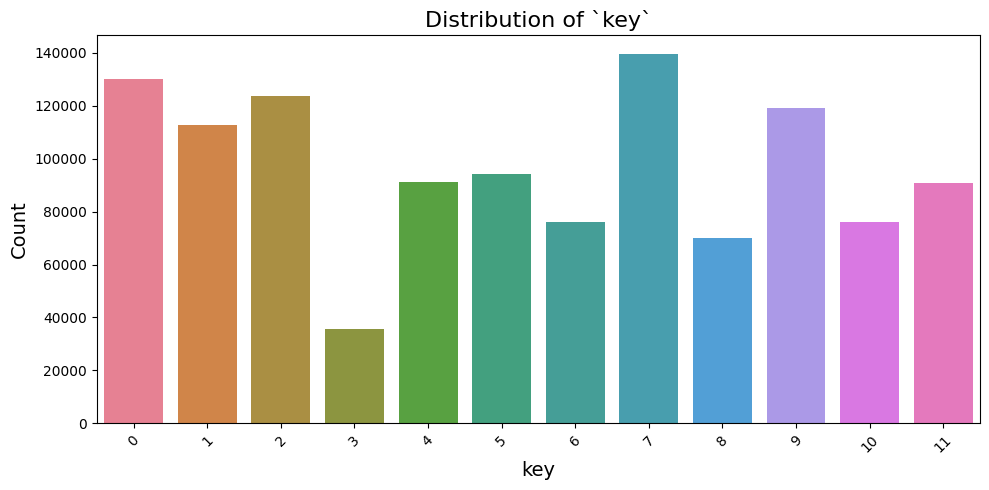

/tmp/ipython-input-2832014477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_df, x=var, palette="husl")


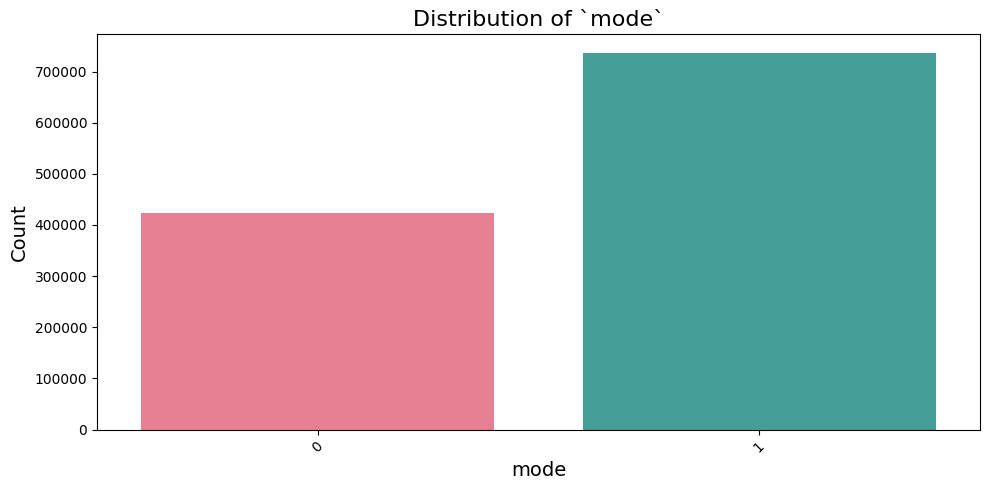

/tmp/ipython-input-2832014477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_df, x=var, palette="husl")


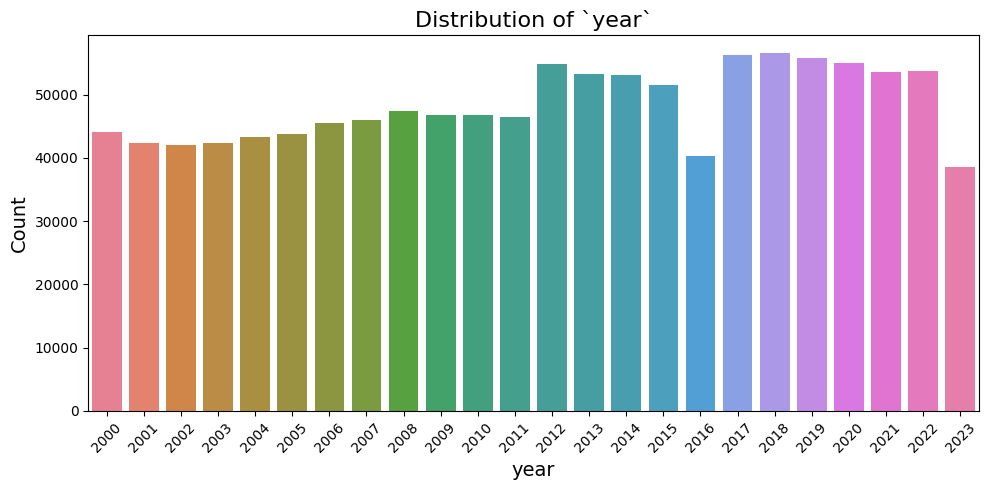

/tmp/ipython-input-2832014477.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_df, x=var, palette="husl")


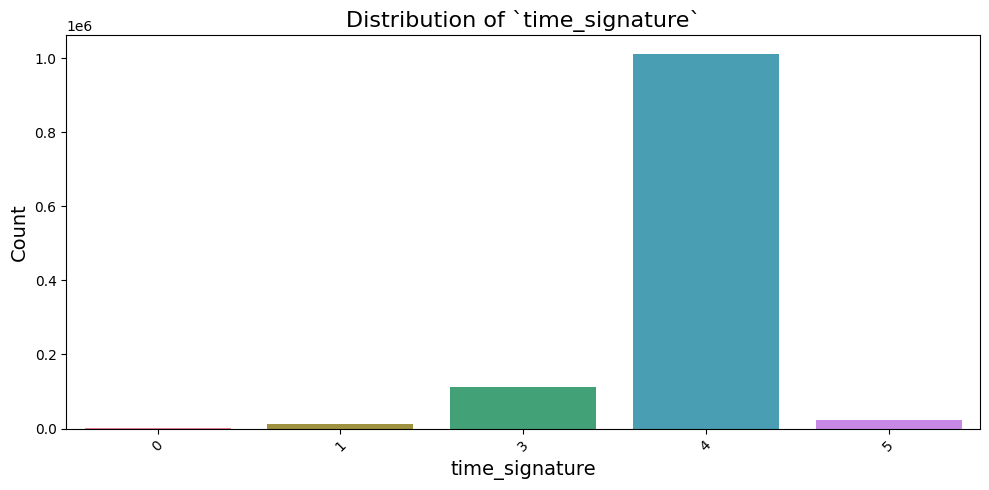

/tmp/ipython-input-2832014477.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=spotify_df, x='popularity_bin', palette="husl")


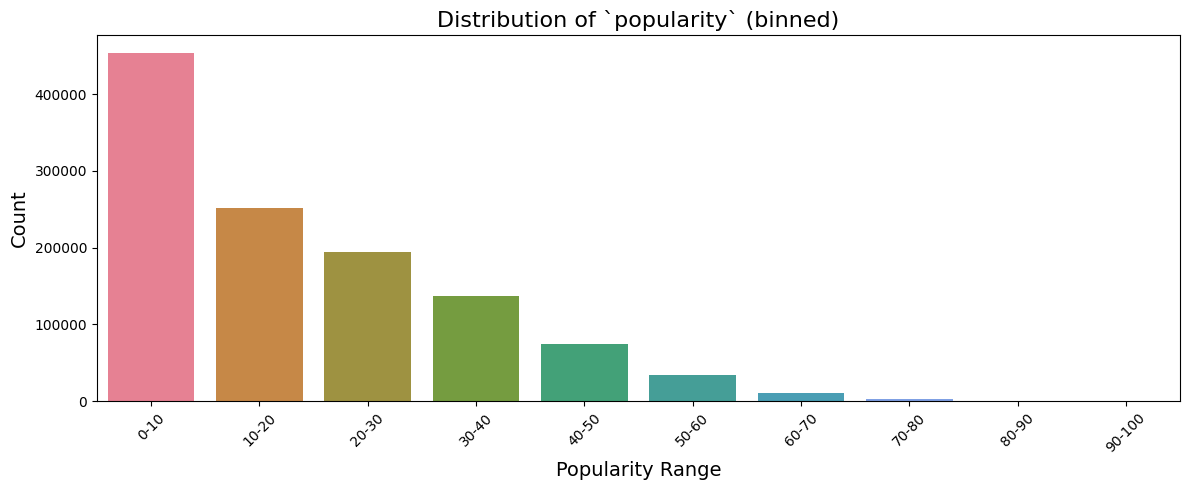

In [ ]:
for var in ['key', 'mode', 'year', 'time_signature']:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=spotify_df, x=var, palette="husl")
    plt.title(f"Distribution of `{var}`", fontsize=16)
    plt.xlabel(var, fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Binned popularity

# Create 10 bins (0–10, 10–20, ..., 90–100)
spotify_df['popularity_bin'] = pd.cut(
    spotify_df['popularity'],
    bins=10,
    labels=[f"{i*10}-{(i+1)*10}" for i in range(10)]
)

plt.figure(figsize=(12, 5))
sns.countplot(data=spotify_df, x='popularity_bin', palette="husl")
plt.title("Distribution of `popularity` (binned)", fontsize=16)
plt.xlabel("Popularity Range", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Interpretation of Discrete Variable Distributions**

- **`key` and `year` appear evenly distributed across the dataset.**  
  Although `key = 3` has the lowest count, it still occurs frequently enough to be considered well-represented. Similarly, the `year` variable shows a fairly balanced spread from 2000–2023, with 2016 and 2023 having slightly fewer entries, though still in non-negligible amounts.

- **`mode` shows a clear imbalance.**  
  There is a noticeably higher count of `mode = 1` (major) compared to `mode = 0` (minor). This suggests that the dataset contains substantially more tracks in major keys than in minor keys.

- **`time_signature` shows a strong imbalance.**  
  The dataset is heavily dominated by `time_signature = 4`, which represents the standard 4/4 time commonly used in most modern music. This dominance is expected, as 4/4 is the most prevalent meter across popular genres.  
  Other time signatures (such as 3, 5, or 1) appear far less frequently. Although their counts are much smaller, they still occur consistently enough to be considered valid observations rather than anomalies.

- **`popularity` was binned for cleaner visualization.**  
  Since the raw values range from 0–100, using a bar plot with all 101 categories would be visually cluttered. After binning into 10-point intervals, the distribution shows a strong **right skew**, with the majority of tracks falling into the **0–10 popularity** range. This indicates that a large proportion of the dataset consists of tracks with relatively low popularity scores.



Lastly, among the remaining object-type variables, the only one worth visualizing is `genre`. Plotting the genre distribution allows us to see how widely different genres are represented in the dataset and whether the frequencies are reasonably balanced. This is important because we want our dataset to contain a diverse and sufficiently broad set of genre labels. A wide coverage ensures that we have enough examples across different musical styles, which is valuable both for understanding the dataset and for supporting downstream tasks such as evaluating or guiding our clustering models.


/tmp/ipython-input-3628764168.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


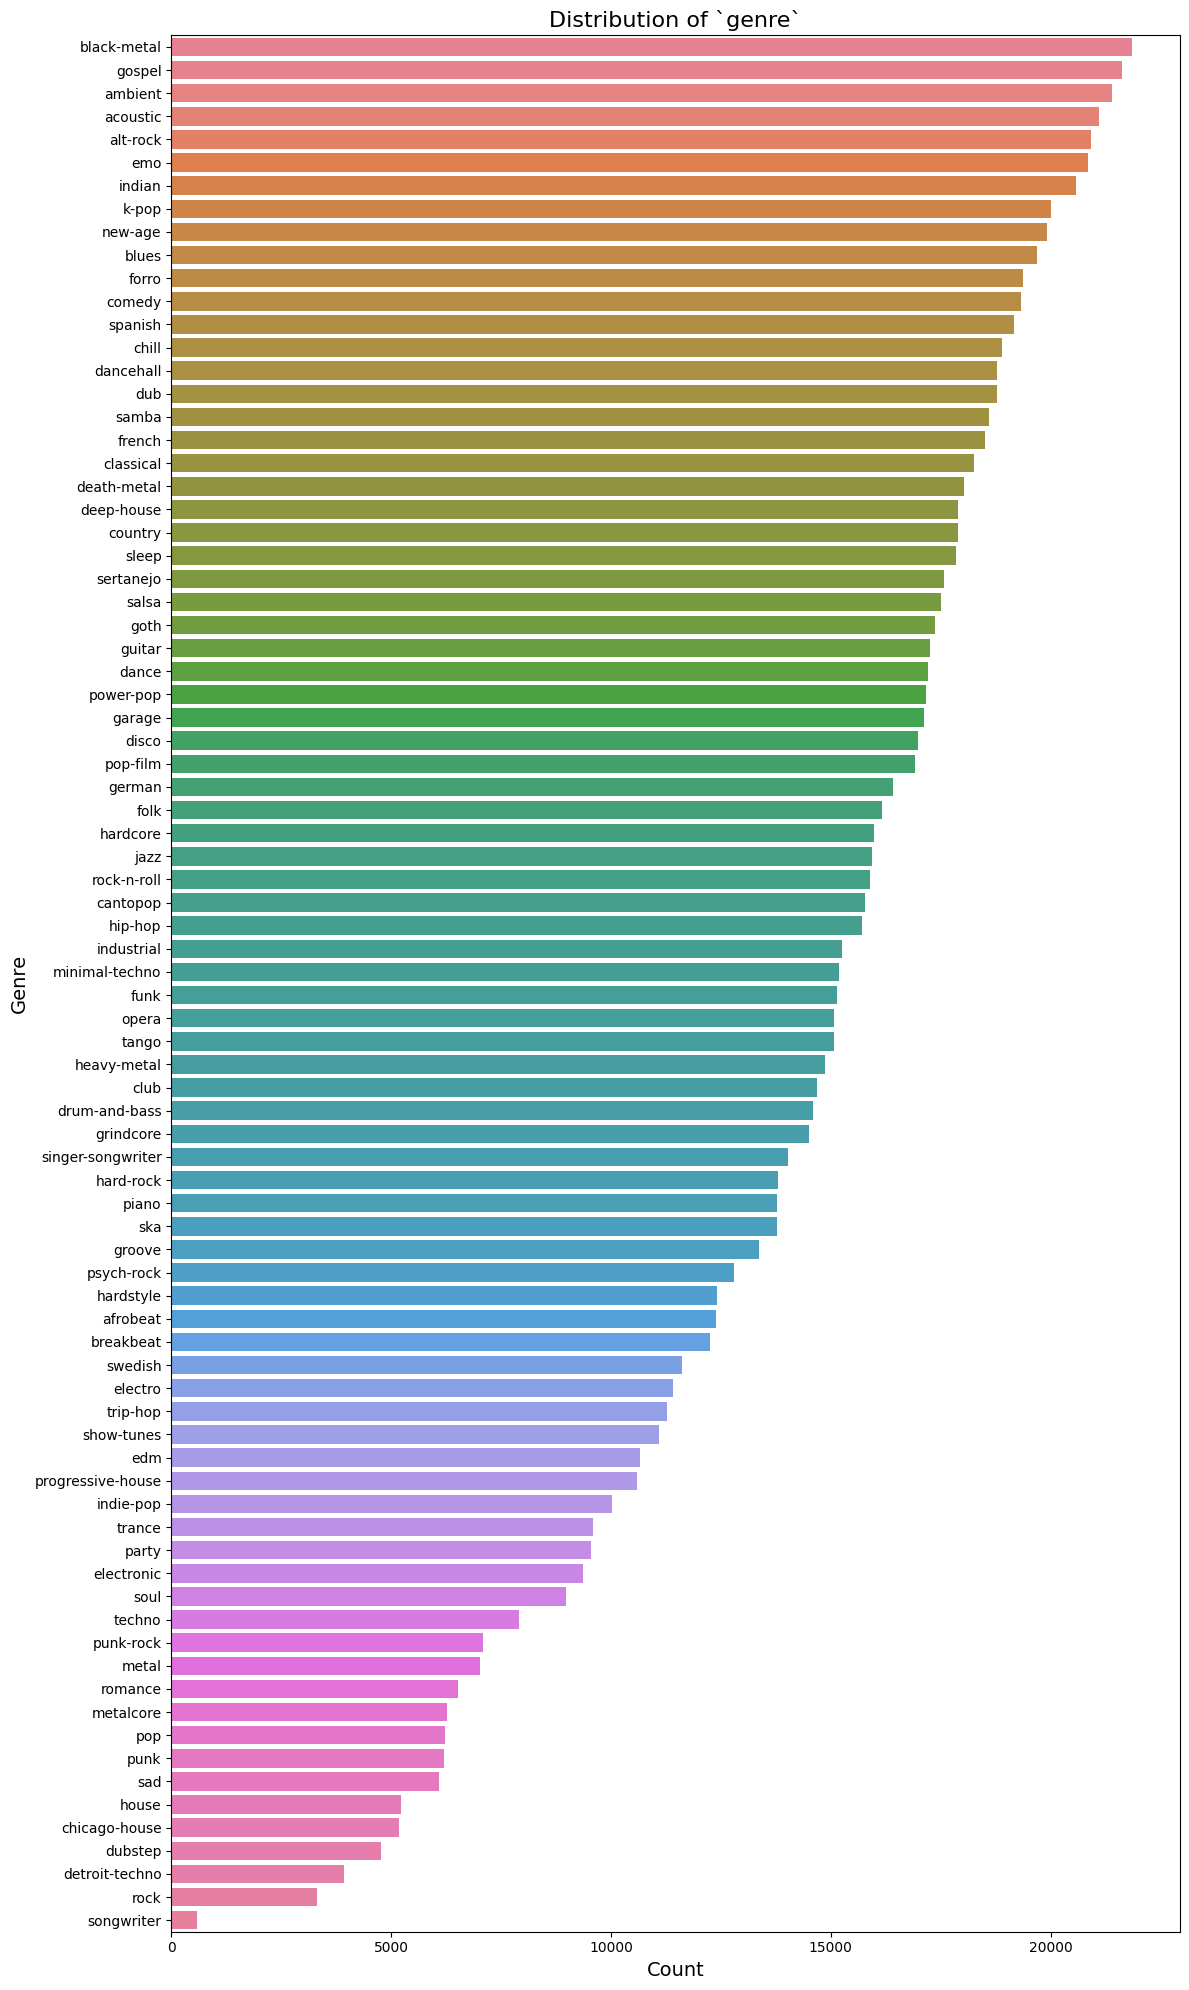

In [ ]:
plt.figure(figsize=(12, 20))
sns.countplot(
    data=spotify_df,
    y='genre',
    order=spotify_df['genre'].value_counts().index,
    palette='husl'
)

plt.title("Distribution of `genre`", fontsize=16)
plt.xlabel("Count", fontsize=14)
plt.ylabel("Genre", fontsize=14)
plt.tight_layout()

plt.show()


**Interpretation of Genre Distribution**

The distribution of `genre` labels shows that the dataset contains a **broad and diverse range of musical genres**, with all 82 categories represented with a substantial number of tracks. This is a positive sign for downstream tasks such as clustering, since it indicates that the dataset is not dominated by only a handful of genres.

However, the distribution is **not perfectly uniform**. Some genres—such as `black-metal`, `gospel`, `ambient`, and `acoustic`—have noticeably higher counts, while others like `songwriter`, `detroit-techno`, and `house` appear less frequently. Even so, the lower-frequency genres still have thousands of examples, which means they are **not negligible** and should remain informative for analysis.

Overall, the dataset provides **good coverage across many different musical styles**, with enough examples in each genre to support meaningful modeling and interpretation. While certain genres are more common than others, the distribution remains relatively balanced for a dataset of this size and diversity.


Now that we have explored all key distribution plots, we can turn our attention to the numerical feature columns and examine whether any multicollinearity is present among them. We use **Spearman rank correlation** here because many of our numerical features are non-normally distributed, heavily skewed, or behave in a quasi-ordinal manner. Unlike Pearson correlation, which only captures linear relationships, Spearman correlation detects **monotonic (non-linear) associations**, making it a more robust choice for understanding dependencies among features such as `instrumentalness`, `speechiness`, and `acousticness`

## Part 4.3: Correlation Matrix

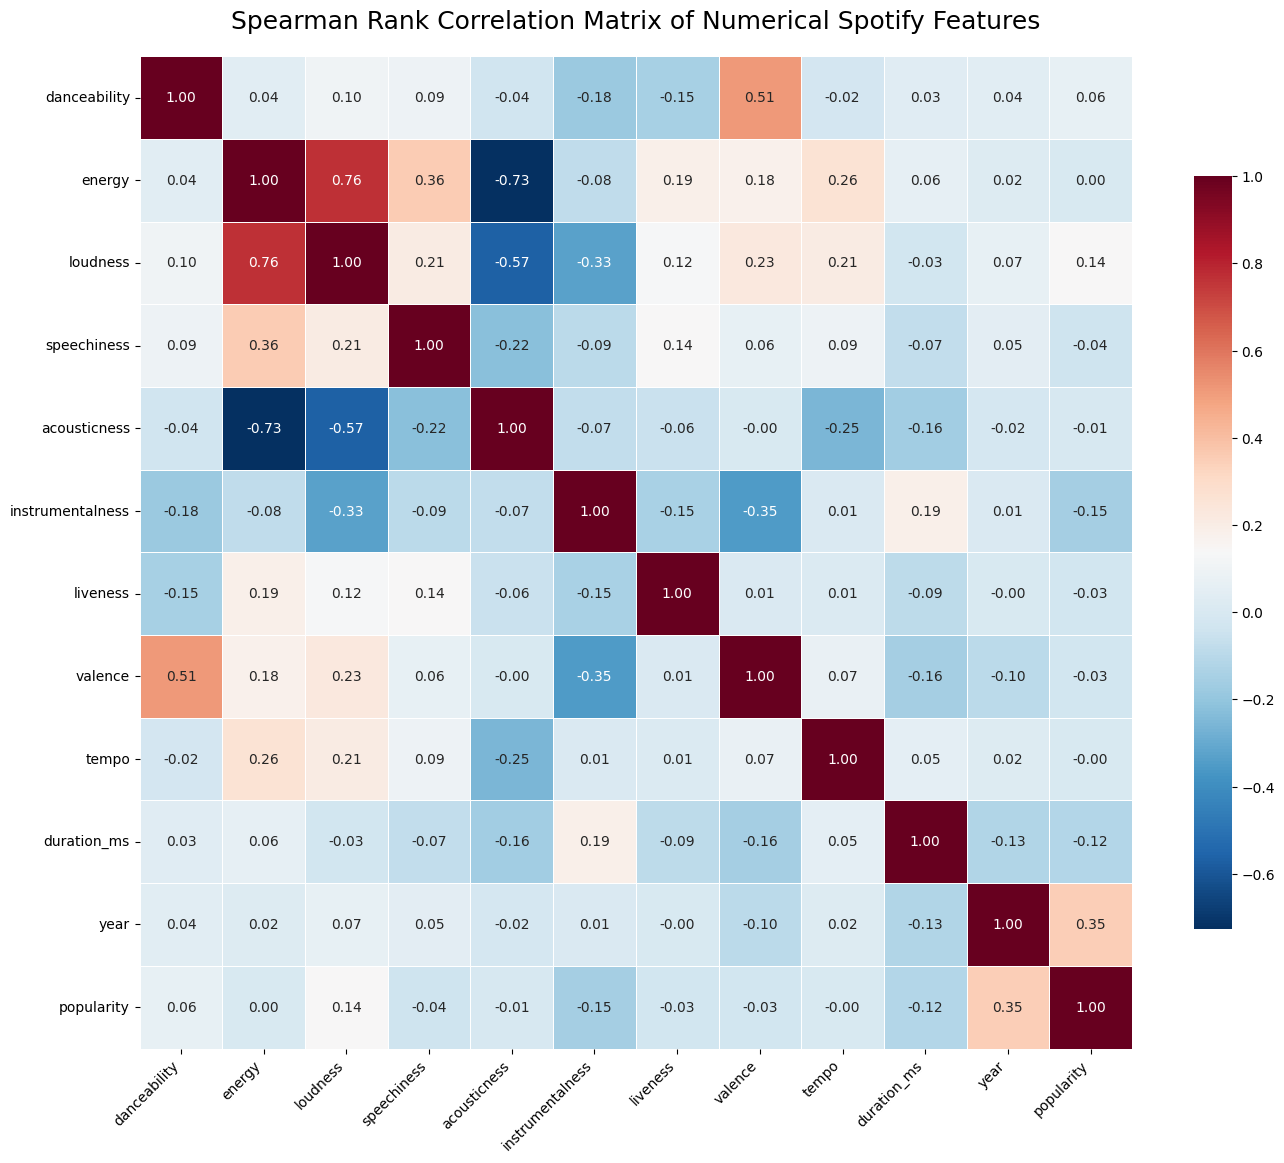

In [ ]:
# Compute Spearman correlation
spearman_corr = spotify_df[numerical_columns + ['year', 'popularity']].corr(method='spearman')

plt.figure(figsize=(14, 12))
sns.heatmap(
    spearman_corr,
    annot=True,
    cmap='RdBu_r',
    linewidths=0.5,
    fmt='.2f',
    cbar_kws={'shrink': 0.7},
    square=True
)

plt.title("Spearman Rank Correlation Matrix of Numerical Spotify Features", fontsize=18, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The strongest correlation in the matrix is between `energy` and `loudness` (0.76), which aligns well with Spotify’s feature definitions—`energy` explicitly incorporates aspects of loudness and perceived intensity. However, no pair of variables exceeds the standard multicollinearity threshold of **0.80**, meaning we do not observe sufficiently high correlations to justify removing any features from the dataset.

A notable negative correlation appears between `energy` and `acousticness` (-0.73). This relationship is intuitive: tracks that are louder, more intense, and more energetic tend to rely less on acoustic instrumentation, while highly acoustic tracks are typically softer and lower in energy.

Similarly, `loudness` and `acousticness` show a moderately strong negative correlation (-0.57), which reflects the same underlying trend—acoustic songs, by definition, tend to be quieter and less forceful than highly amplified or electronically produced tracks.

Another meaningful positive correlation is observed between `danceability` and `valence` (0.51). This makes sense musically: tracks that convey positive, uplifting, or euphoric moods often feature rhythmic stability, clear beats, and tempos that lend themselves to dancing, contributing to higher danceability scores.

Overall, while several correlations align with musical intuition and Spotify’s feature definitions, none exceed the multicollinearity threshold. Thus, all numerical features can be retained for subsequent modeling and clustering steps.


## Part 4.4: Missing Value Inspection

Our next step in the EDA process is to examine missing values. Although we briefly noted missingness earlier, we now perform a more explicit and systematic inspection of null entries across the dataset.

In [ ]:
spotify_df.isna().sum()

,0
artist_name,15
track_name,1
track_id,0
popularity,0
year,0
genre,0
danceability,0
energy,0
key,0
loudness,0


Next, we take a closer look at the missing values in the dataset. We observe that `artist_name` contains 15 null entries, while `track_name` has 1 null entry. To better understand these cases, we will inspect the specific rows where these missing values occur to determine their source and whether they require cleaning or removal.

In [ ]:
spotify_df[spotify_df['artist_name'].isnull() | spotify_df['track_name'].isnull()]

,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_bin
256971,NaN,Cold,10eyeJsKDh26SKEBvSfuBG,17,2017,black-metal,0.2120,0.7080,7,-6.932,1,0.2180,0.000201,0.9060,0.1430,0.0381,126.739,717237,4,10-20
256972,NaN,Wither,6xz1O7tOw6Tdvzc3Ev1isc,16,2017,black-metal,0.3170,0.5180,9,-7.418,1,0.0650,0.000258,0.8550,0.7290,0.0747,110.958,525099,4,10-20
257024,NaN,Suffer,6hedSqpvIaW0GzrqJnq32D,14,2017,black-metal,0.1090,0.1420,2,-11.807,0,0.0439,0.154000,0.8790,0.1050,0.0350,57.422,565664,3,10-20
313028,NaN,"A World, Dead and Gray",7shu4LrpMTsGwa8YotA1My,26,2018,black-metal,0.3770,0.5070,7,-14.889,1,0.0448,0.000103,0.9310,0.2110,0.3380,113.917,466182,4,20-30
313050,NaN,Hypoxic,3V8qpQnLVhu82ZvC4Ja8VG,24,2018,black-metal,0.3410,0.4260,11,-17.450,0,0.0496,0.038000,0.8480,0.1130,0.0404,66.628,418945,4,20-30
313063,NaN,Bed the Cold Earth,68w6nJMmA9Ui6zV7qXrwIt,22,2018,black-metal,0.1650,0.4610,10,-16.267,1,0.0378,0.001410,0.7890,0.1030,0.1220,72.501,464632,4,20-30
313117,NaN,Life Is Long Enough,1NJ8HTD5syI65EJmXUckxB,20,2018,black-metal,0.1800,0.1400,7,-18.017,0,0.0440,0.230000,0.9250,0.1110,0.0357,86.924,476152,4,10-20
313153,NaN,Corroded,4zcJ5p91PSG3vDsGJfENDd,17,2018,black-metal,0.1490,0.1440,2,-21.518,0,0.0321,0.771000,0.8590,0.1120,0.0398,85.413,317214,4,10-20
313174,NaN,Desiderate,6375ZIE3Pi8BuZOuy8f6g1,16,2018,black-metal,0.1630,0.3210,7,-17.123,0,0.0411,0.148000,0.3240,0.1140,0.0535,66.017,472719,4,10-20
313225,NaN,Where Life Should Be,0VCAJwhy4p3tVaGUSnaWGr,15,2018,black-metal,0.1910,0.1630,0,-15.242,0,0.0378,0.102000,0.9070,0.0875,0.0383,137.785,530210,3,10-20


After examining the rows containing missing values, we find that all null entries in `artist_name` correspond to Black Metal tracks released between 2017 and 2019. This strongly suggests that these entries likely belong to the same artist. By searching the track names directly on Spotify, we confirm that the artist’s actual name is ‘None’. Because the string 'None' was misinterpreted as a null value during data ingestion, it appears in the dataset as NaN.

A similar issue occurs with the single null value in `track_name`: the track’s actual title is also 'None', which again was incorrectly parsed as a missing value.

Since all null values are the result of this parsing behavior—and the intended value in each case is literally the string 'None'—we will replace all NaN values in both artist_name and track_name with the string 'None'.

In [ ]:
spotify_df['artist_name'] = spotify_df['artist_name'].fillna('None')
spotify_df['track_name'] = spotify_df['track_name'].fillna('None')

## Part 4.5 Outlier Detection

Next, we examine the dataset for potential outliers. Identifying outliers is a crucial step because extreme or anomalous values can distort distance-based clustering algorithms and lead to incorrect group assignments. By detecting these points early, we can decide whether they should be removed, transformed, or handled separately before proceeding with modeling.

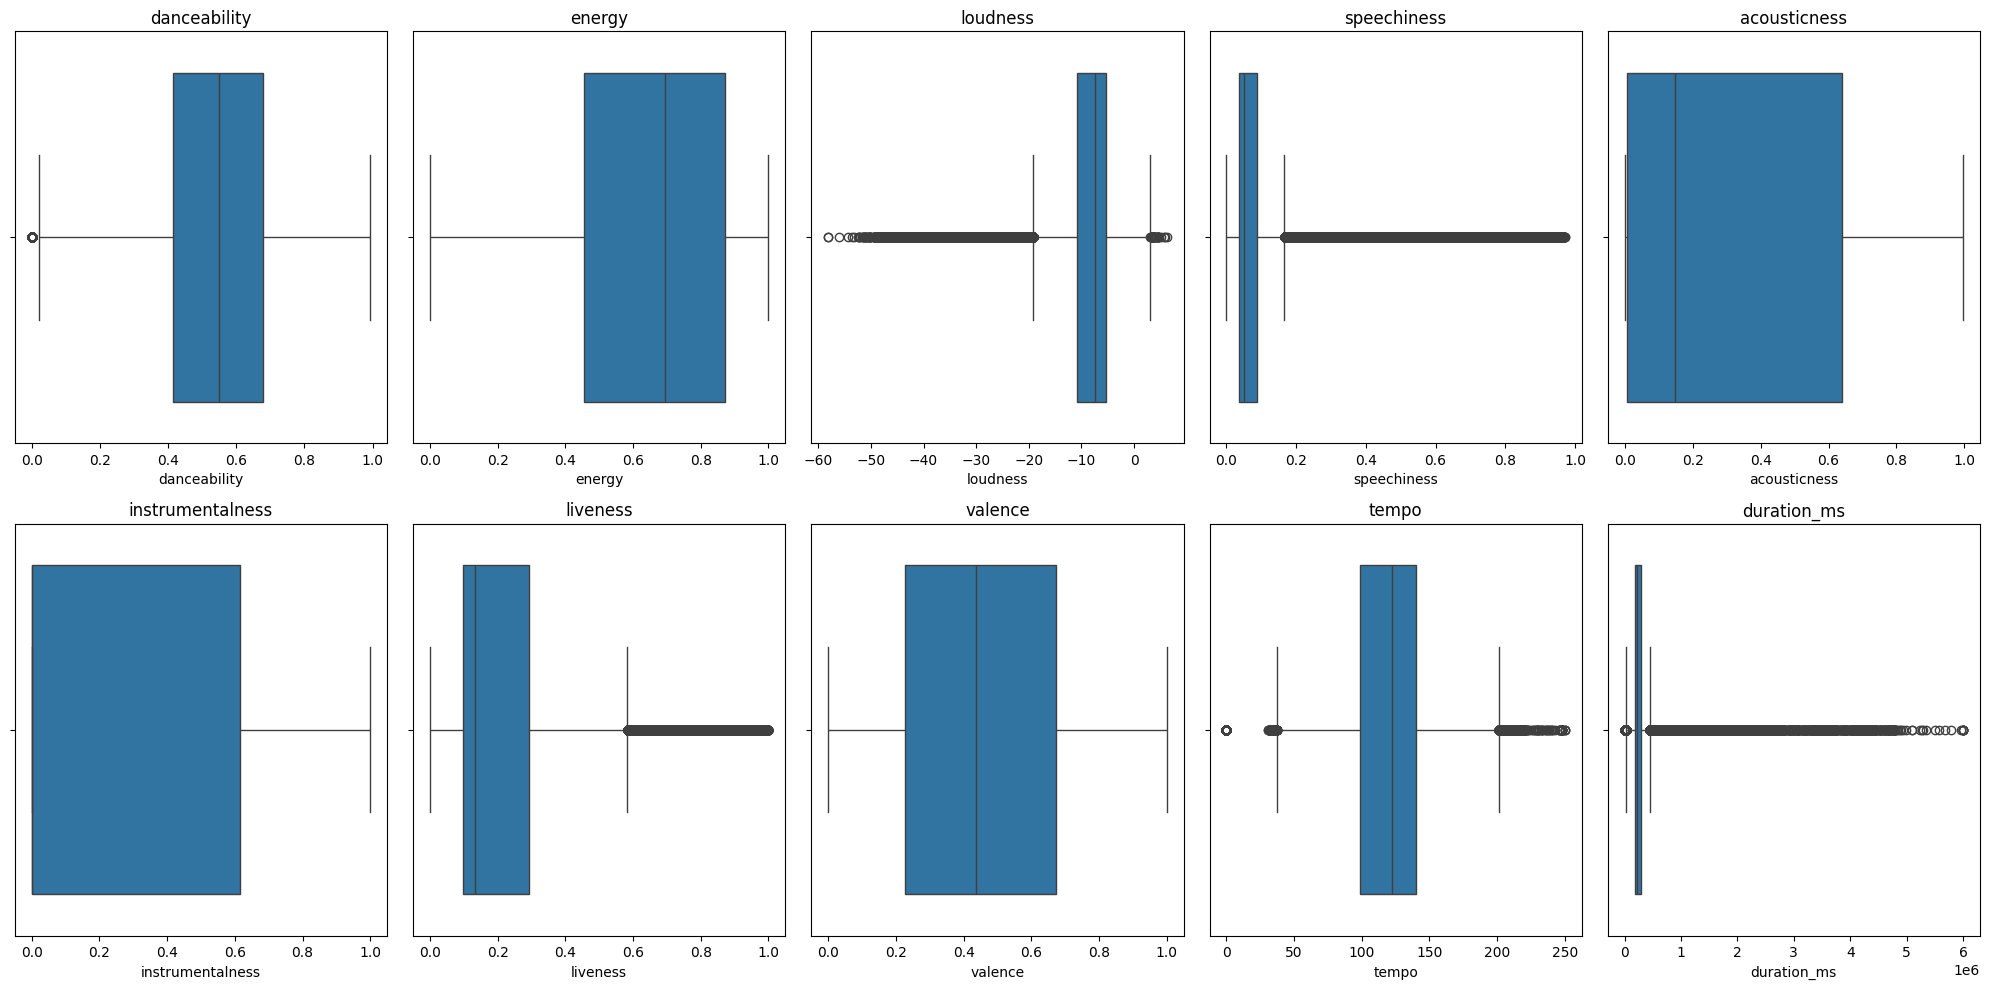

In [ ]:
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for i, feature in enumerate(numerical_columns):
  sns.boxplot(data = spotify_df, x = feature, ax = axes[i])
  axes[i].set_title(feature)
plt.tight_layout()
plt.show()

After reviewing the box-and-whisker plots for each numerical feature, we observe that`instrumentalness`, `energy`, `valence`, and `acousticness` display no outliers. All values fall within the expected range for these features, indicating stable distributions without unusual observations.

`danceability` contains only a single mild outlier near the lower whisker. Because this value lies close to the boundary of the interquartile range, it does not meaningfully affect the distribution and is not considered problematic.

In contrast, `liveness`, `tempo`, `duration_ms`, and `speechiness` exhibit a greater number of outliers. For `speechiness`, `duration_ms`, and `liveness`, most outliers appear above the upper quartile, reflecting the right-skewed shape of their distributions. `loudness` shows the opposite pattern, with more outliers below the lower quartile, while `tempo` presents a more even spread of outliers on both ends.

These findings are consistent with the earlier density plots: features with skewed distributions naturally produce more extreme values, which is reflected in the box-and-whisker diagrams.

Because the outliers represent genuine characteristics of the songs—not data-entry errors—we do not treat them as anomalies requiring removal or correction. Eliminating them would risk discarding meaningful variation present in the dataset.

Therefore, we choose to **retain all outlier observations** rather than drop or modify them.


## Part 4.6 Further Data Inspection and Correction

Upon reviewing the summary statistics, we notice that the minimum value of `time_signature` in our dataset is 0, even though the Spotify API documentation states that valid time signatures range from 3 to 7. When we examine the value counts, we see that 1,228 tracks have a `time_signature` of 0 and 12,660 tracks have a value of 1.

At first, we considered whether these values might represent special musical cases—such as songs without a clear rhythmic structure (e.g., spoken word or ambient tracks). However, after further inspection, we found that tracks with `time_signature` values of 0 and 1 appear across nearly every genre in the dataset. This broad distribution makes it unlikely that these values represent meaningful musical time signatures.

Instead, these values are most likely the result of Spotify’s beat-tracking algorithm failing to confidently determine a time signature. Although the API lists only 3–7 as valid outputs, large datasets often contain additional fallback values (such as 0 or 1) that arise from low-confidence or error states in the audio analysis pipeline.

Given that these values fall outside the documented valid range and are not musically interpretable, we treat them as erroneous and remove all rows where `time_signature` is 0 or 1.


In [ ]:
#time signature value counts
spotify_df["time_signature"].value_counts()

,count
time_signature,
4,1010673
3,112332
5,22871
1,12660
0,1228


In [ ]:
#Detection of time signature = 0 and time signature =1 across genres
bad_time_signature = spotify_df[(spotify_df["time_signature"] == 1) | (spotify_df["time_signature"] == 0)]
bad_time_signature["genre"].value_counts()

,count
genre,
sleep,1760
comedy,961
grindcore,816
ambient,803
classical,621
...,...
rock,10
songwriter,8
breakbeat,8


In [ ]:
spotify_df = spotify_df[(spotify_df["time_signature"] != 0) & (spotify_df["time_signature"] != 1)]
len(spotify_df)

1145876

According to the Spotify API documentation, the popularity of a track is computed algorithmically based on two main factors: the total number of plays the track has received and how *recent* those plays are. This presents a challenge for our analysis because popularity is a **time-dependent metric**. The values in our dataset represent popularity scores at one frozen moment in time, not stable or intrinsic properties of the songs themselves.

Because popularity fluctuates constantly—especially for tracks affected by seasonal trends or sudden shifts in listener behavior—using this feature for clustering would introduce noise rather than meaningful structure. Two identical songs could have very different popularity scores simply due to differences in timing, marketing cycles, or recent playlist placements.

Given that popularity is not a static musical characteristic and varies independently of the audio features we intend to study, we conclude that it is not an appropriate variable for our clustering analysis. Therefore, we remove the `popularity` column entirely from the dataset.


In [ ]:
#Dropping popularity feature from the dataset
spotify_df = spotify_df.drop(columns = {'popularity', 'popularity_bin'})

## Part 4.7 Entity Linking/External Model Integration

As part of our entity linking and external model integration, we extract semantic information from each `track_name` based on the idea that titles often contain textual cues indicative of musical genre. For example, words like “cowboy,” “whiskey,” or “heartland” may suggest a country track, while titles containing terms like “symphony” or “nocturne” may hint at classical music. By embedding this information, the model can leverage linguistic patterns that frequently align with genre categories.

To capture these cues, we use the pretrained `all-MiniLM-L6-v2` model from the sentence-transformers library on Hugging Face. This lightweight yet powerful encoder maps each track title into a 384-dimensional vector that summarizes its semantic meaning. The model’s transformer architecture includes a projection layer that compresses contextual information into a compact representation, striking an effective balance between expressiveness, speed, and computational efficiency.

These embeddings are well suited for downstream tasks such as semantic similarity, clustering, information retrieval, and classification. In our setting, they provide a dense, information-rich representation of each track name, improving the model’s ability to learn genre-relevant textual patterns.

In [ ]:
#Name of the pretrained sentence embedding model we will be using
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

In [ ]:
#Load the model's tokenizer (handles text--> tokens)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#Load the pretrained MiniLM model itself (handles tokens--> embeddings)
model = AutoModel.from_pretrained(MODEL_NAME)

#Set the model to evaluation mode, since we are only encoding text, not training
model.eval()

#Select the device: use GPU if available, otherwise default
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Move the model to the selected device for faster computation
model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)


Now we define the standard mean-pooling operation used to create sentence embeddings from a Transformer model's token-level outputs. Mean pooling aggregates the hidden states of all non-padded tokens into a single fixed-size vector by averaging the token embeddings according to the attention mask. This produces a compact, semantically meaningful embedding for the entire input sentence.


In [ ]:
def mean_pooling(model_output, attention_mask):
    #Extract the token embeddings from the model output
    #Shape: (batch size, sequence length, hidden_dim)
    token_embeddings = model_output.last_hidden_state


    #Expand the attention mask so it can be applied to every hidden dimension
    #Original mask shape: (batch_size, sequence_length)
    #After unsqueeze + expand: (batch_size, sequence_length, hidden_dim)
    #This allows us to zero-out padded token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

    #Multiply embeddings by the mask and sum across the sequence dimension
    #This sums only the embeddings of non-padded tokens
    summed = (token_embeddings * input_mask_expanded).sum(dim=1)

    #Count how many tokens were not masked for each example
    #clamp(min=le-9) avoids division by zero in edge cases
    counts = input_mask_expanded.sum(dim=1).clamp(min=1e-9)

    #Return the mean-pooled embedding for each example
    #(sum over real tokens) / (number of real tokens)
    return summed / counts




And here we define the embed_track_names function, which computes sentence embeddings for a list of track names using a Transformer encoder+ mean pooling. The function returns a NumPy array of shape (n_tracks, embedding_dim) containing one embedding vector per track name.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def embed_track_names(track_names, batch_size=64, max_length=16):
    """
    track_names: pandas Series or list of track title strings
    returns: np.array of shape (n_tracks, embedding_dim)
    """
    all_embeddings = []
    n = len(track_names)

    #Disable gradient computation-we are only encoding, not training
    with torch.no_grad():

        #Process the track name in batches for efficiency
        for start in range(0, n, batch_size):
            #Slice the next batch of track names
            batch_text = track_names[start:start+batch_size].tolist()


            #Tokenize the text into input ID's + attention masks
            #padding = True ensures equal sequence lengths within the batch
            #truncation=True ensures sequences longer than max_length are cut
            #return_tensors="pt" returns PyTorch tensors directly
            encoded = tokenizer(
                batch_text,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )

            #Move tokenized inputs (input_ids, attention mask) to the device (GPU)
            encoded = {k: v.to(device) for k, v in encoded.items()}

            #Run the batch through the Transformer model
            model_output = model(**encoded)

            #Convert per-token embeddings to a single embedding per track
            #using our mean pooling function
            batch_embeddings = mean_pooling(model_output, encoded["attention_mask"])

            #Move embeddings back to CPU and ammend to running list
            all_embeddings.append(batch_embeddings.cpu())

    #Concatenate all batches into one large (n_tracks, embedding_dim) matrix
    return torch.cat(all_embeddings, dim=0).numpy()


The output of `embed_track_names` is a NumPy array of shape (n_tracks, 384), as explained earlier. Every row in the embedding matrix corresponds to a single song, and each column represents one dimension of the learned semantic embedding space. These embeddings provide a dense numerical representation of the textual information contained in the track names, which can be used directly as input features for clustering or downstream modeling.

In [ ]:
track_embeddings = embed_track_names(spotify_df["track_name"])

print(track_embeddings.shape)  # (n_tracks, 384) for MiniLM

(1145876, 384)


To demonstrate the semantic structure learned by the embedding model, we selected a set of genre-indicative track names and computed the cosine similarity between their embedding vectors. The resulting heatmap provides a clear visual picture of how the model groups similar titles and separates dissimilar ones.

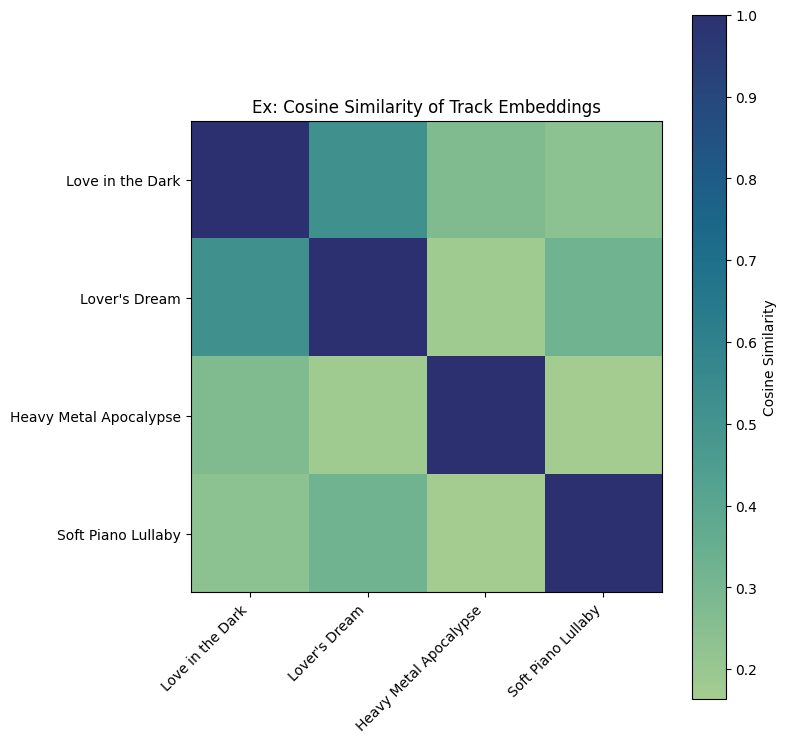

In [ ]:
# Choose a small sample of track names for demonstration
sample_tracks = [
    "Love in the Dark",
    "Lover's Dream",
    "Heavy Metal Apocalypse",
    "Soft Piano Lullaby"
]

# Option 1: make it a pandas Series
sample_tracks_series = pd.Series(sample_tracks)
sample_embeddings = embed_track_names(sample_tracks_series)

# (Option 2: use a NumPy array – also works)
# sample_tracks_array = np.array(sample_tracks)
# sample_embeddings = embed_track_names(sample_tracks_array)

# Compute cosine similarity matrix
sim_matrix = cosine_similarity(sample_embeddings)

# Plot the similarity heatmap
plt.figure(figsize=(8, 8))
plt.imshow(sim_matrix, cmap="crest")
plt.colorbar(label="Cosine Similarity")
plt.xticks(range(len(sample_tracks)), sample_tracks, rotation=45, ha="right")
plt.yticks(range(len(sample_tracks)), sample_tracks)
plt.title("Ex: Cosine Similarity of Track Embeddings")
plt.tight_layout()
plt.show()

## Part 4.8: Feature Engineering

In this section, we outline the feature engineering strategies used to enhance clustering performance. We discuss how certain audio features were transformed, why these modifications were necessary, and how they help produce representations that are more meaningful for the clustering task. Our goal is to refine the dataset in ways that reduce noise, emphasize structure, and ultimately improve the quality of the learned clusters.

Building on the insights from the density plots, we observed that several numerical audio features—`instrumentalness`, `speechiness`, and `acousticness`—do not behave like smooth continuous variables. Instead, each of them exhibits a clustered, quasi-binary (or quasi-ordinal) structure, with most tracks concentrated near 0 and a secondary cluster forming near 1.

Because of this strongly bimodal behavior, treating these features as continuous introduces unnecessary variability and weakens the interpretability of the downstream model. To better capture the patterns implied by Spotify’s definitions—and to align the feature representation with the inherent data structure—we transformed these features into categorical bins.

In [ ]:
# Instrumentalness: binary indicator
spotify_df["instrumentalness"] = (spotify_df["instrumentalness"] > 0.5).astype(int)

# Speechiness: ordinal categorical (0 = musical, 1 = mixed, 2 = spoken)
spotify_df["speechiness"] = spotify_df["speechiness"].apply(lambda x: 2 if x > 0.66 else 1 if x > 0.33 else 0)


# Acousticness: binary indicator for high vs. low acoustic presence
spotify_df["acousticness"] = (spotify_df["acousticness"] > 0.5).astype(int)

Now we introduce several engineered features using DuckDB, which allows us to efficiently compute multiple transformations in a single SQL query. This approach keeps the workflow organized, avoids the overhead of modifying the DataFrame repeatedly in Python, and makes it easy to define new variables directly alongside the existing schema. In this step, we generate three new features: `artist_track_count`, `energy_danceability` (the interaction between energy and danceability), and `title_length` (the character length of the track name). DuckDB’s SQL interface enables us to create all of these features at once in a clear, modular way that integrates smoothly with the rest of the preprocessing pipeline.

In [ ]:
# 1. Register your DataFrame as a DuckDB table
duckdb.register('tracks', spotify_df)

# 2. Run SQL with engineered features
query = """
SELECT
    t.*,
    ac.artist_track_count,
    (t.energy * t.danceability) AS energy_danceability,
    length(t.track_name)        AS title_length
FROM tracks t
LEFT JOIN (
    SELECT artist_name, COUNT(*) AS artist_track_count
    FROM tracks
    GROUP BY artist_name
) ac USING (artist_name);
"""

spotify_df = duckdb.query(query).df()
spotify_df[['artist_name', 'energy', 'danceability', 'track_name','artist_track_count', 'energy_danceability', 'title_length']].head()


,artist_name,energy,danceability,track_name,artist_track_count,energy_danceability,title_length
0,Jason Mraz,0.303,0.483,I Won't Give Up,193,0.146349,15
1,Jason Mraz,0.454,0.572,93 Million Miles,193,0.259688,16
2,Joshua Hyslop,0.234,0.409,Do Not Let Me Go,61,0.095706,16
3,Boyce Avenue,0.251,0.392,Fast Car,335,0.098392,8
4,Andrew Belle,0.791,0.430,Sky's Still Blue,66,0.340130,16


1. **`artist_track_count`(number of tracks per artist in the dataset)**

    This feature quantifies how frequently each artist appears in the dataset. Many artists tend to produce music within a consistent stylistic range, and repeated appearances provide the model with stronger evidence about an artist’s typical genre.
    Higher values highlight artists with large discographies in the dataset, while lower counts indicate sparse representation.
    This acts as a form of artist-level prior, giving the model contextual information about how strongly an artist aligns with particular genres.

2. **`energy_danceability` (interaction between `energy` and `danceability`)**

    While energy and danceability are useful individually, their interaction captures musical characteristics that emerge only when considering the two measurements together.
    Genres often cluster along combinations of these values—for example, high energy and high danceability commonly correspond to electronic or pop tracks, whereas low danceability with high energy may indicate rock or metal.
    This interaction term therefore captures subtle nonlinear structure in the audio space that single features alone cannot express.

3. **`title_length` (character length of the track name)**

    Track titles exhibit meaningful stylistic variation across genres. Some genres (e.g., indie, folk) favor longer, more descriptive titles, while genres like pop, EDM, or hip-hop often use shorter, more concise naming conventions.
    By quantifying the length of each title, this feature introduces lightweight textual information that complements the audio-based features.
    Although simple, it captures tendencies in artistic expression and genre-specific naming patterns.

Next, we create a boolean column that identifies whether an artist is likely a group rather than a solo performer. To motivate this feature, we first analyze the `artist_name` field using regex patterns commonly associated with groups—such as “&”, “and”, collaboration markers, or ensemble-related terms. This initial exploration allows us to quantify how often such patterns appear in the dataset.

In [ ]:

patterns = {
    "ampersand (&)": r"&",
    "comma (,)": r",",
    "and": r"\band\b",
    "feat / featuring": r"\bfeat\.?|\bfeaturing\b",
    "x (artist x artist)": r"\bx\b",
    "vs": r"\bvs\.?\b",
    "band": r"\bband\b",
    "orchestra": r"\borchestra\b",
    "choir": r"\bchoir\b",
    "ensemble": r"\bensemble\b",
    "trio": r"\btrio\b",
    "quartet": r"\bquartet\b"
}

counts = {}

for label, pattern in patterns.items():
    counts[label] = (
        spotify_df["artist_name"]
        .str.contains(pattern, flags=re.IGNORECASE, regex=True)
        .sum()
    )

pd.DataFrame.from_dict(counts, orient="index", columns=["count"]).sort_values("count", ascending=False)

,count
ampersand (&),28476
and,5304
band,4333
trio,2848
"comma (,)",2285
x (artist x artist),1712
orchestra,1657
ensemble,757
quartet,669
choir,620


From the table above, we observe that several of these patterns occur frequently, indicating that a meaningful number of artists use naming conventions typically associated with groups or multi-performer acts. This validates the idea that a regex-based heuristic may capture useful structure within the data.

Using these insights, we construct a new boolean column that flags whether an artist is likely a group. The feature assigns `1` when the name contains clear markers of multiple performers (e.g., “band”, “trio”, “&”) and `0` otherwise. Although this method is not perfect—and will miss cases where group names do not follow common patterns—it provides a practical approximation.

In downstream tasks such as clustering, this feature may enhance interpretability by helping differentiate stylistic or genre-specific trends between solo artists and groups. It may also reveal broader patterns in how artist type relates to musical characteristics.

In [ ]:
group_pattern = r"""
    (&)|
    (,)|
    (\bfeat\.?\b)|
    (\bfeaturing\b)|
    (\band\b)|
    (\bx\b)|
    (\bvs\.?\b)|
    (\bband\b)|
    (\borchestra\b)|
    (\bchoir\b)|
    (\bensemble\b)|
    (\btrio\b)|
    (\bquartet\b)|
    (\bquintet\b)
"""

def is_group_artist(name: str) -> int:
    if not isinstance(name, str):
        return np.nan
    return int(bool(re.search(group_pattern, name, flags=re.IGNORECASE | re.VERBOSE)))

spotify_df["artist_is_group"] = spotify_df["artist_name"].apply(is_group_artist)

As the final step in our feature engineering pipeline, we apply one-hot encoding to our categorical variables. These include both the original categorical features and the features that we previously transformed into discrete bins. One-hot encoding converts each categorical value into a binary indicator column, ensuring the model can interpret these variables numerically without imposing an artificial ordering.

In [ ]:
# List of categorical features (including previously binned variables)
categorical_features = ["instrumentalness", "speechiness", "mode", "time_signature", "key", "acousticness"]

# Reset index to avoid issues when concatenating new encoded columns later
spotify_df = spotify_df.reset_index(drop=True)

# Initialize OneHotEncoder
# - sparse_output=False returns a dense NumPy array
# - drop=None keeps all categories (no reference category removed)
# - handle_unknown='ignore' avoids errors when unseen categories appear in test data
encoder = OneHotEncoder(sparse_output=False, drop=None, handle_unknown="ignore")

# Fit the encoder to our categorical columns and transform them into OHE vectors
encoded_cols = encoder.fit_transform(spotify_df[categorical_features])

# Remove original categorical columns from the dataset
spotify_df = spotify_df.drop(columns=categorical_features)

# Retrieve the names of the new one-hot encoded columns
encoded_col_names = encoder.get_feature_names_out(categorical_features)

# Add the encoded columns back into the dataframe
spotify_df = pd.concat([spotify_df, pd.DataFrame(encoded_cols, columns=encoded_col_names)],axis=1)

spotify_df.head()

,artist_name,track_name,track_id,year,genre,danceability,energy,loudness,liveness,valence,...,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,acousticness_0,acousticness_1
0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,2012,acoustic,0.483,0.303,-10.058,0.1150,0.139,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,2012,acoustic,0.572,0.454,-10.286,0.0974,0.515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,2012,acoustic,0.409,0.234,-13.711,0.0895,0.145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,2012,acoustic,0.392,0.251,-9.845,0.0797,0.508,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,2012,acoustic,0.430,0.791,-5.419,0.1100,0.217,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Part 5: Modelling

## Part 5.0 Set up Modeling Environment

We start our modelling process by preparing the feature matrix. This involves combining the cleaned numerical audio features with the newly generated track name embeddings to create a comprehensive dataset for clustering.
We then split the data into training, validation, and test sets according to good practice to ensure robust model evaluation and prevent overfitting.

In [ ]:
seed = 101

# Reducing track name embedding dimensionality with PCA - To avoid sparsity issues
pca = PCA(n_components=10)
reduced_embeddings = pca.fit_transform(track_embeddings)
spotify_df = pd.concat([spotify_df.reset_index(drop=True), pd.DataFrame(reduced_embeddings, columns=[f"embed_{i}" for i in range(reduced_embeddings.shape[1])])], axis=1)

n_genres = spotify_df.genre.unique().shape[0]
columns_to_model = [c for c in numerical_columns+[f"embed_{i}" for i in range(reduced_embeddings.shape[1])]
                    if c in spotify_df.columns]
X = spotify_df[columns_to_model]
y = spotify_df['genre']

# Split data into train (60%), val (20%), test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=seed, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=seed, shuffle=True)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Subsampling for efficiency, on strata
subset_size = 10_000
train_subsampled_indices = y_train.groupby(y_train).apply(
    lambda x: x.sample(n=min(len(x), subset_size // n_genres), random_state=seed).reset_index(drop=True).index
).explode().values.astype(int)
X_train_subsampled = X_train_scaled[train_subsampled_indices, :-10]
y_train_subsampled = y_train.values[train_subsampled_indices]

As an initial step, we calculate the pairwise cosine distances between genre centroids. A distance of 0 indicates identity, and a distance of 2 indicates maximum dissimilarity (opposite vector directions).

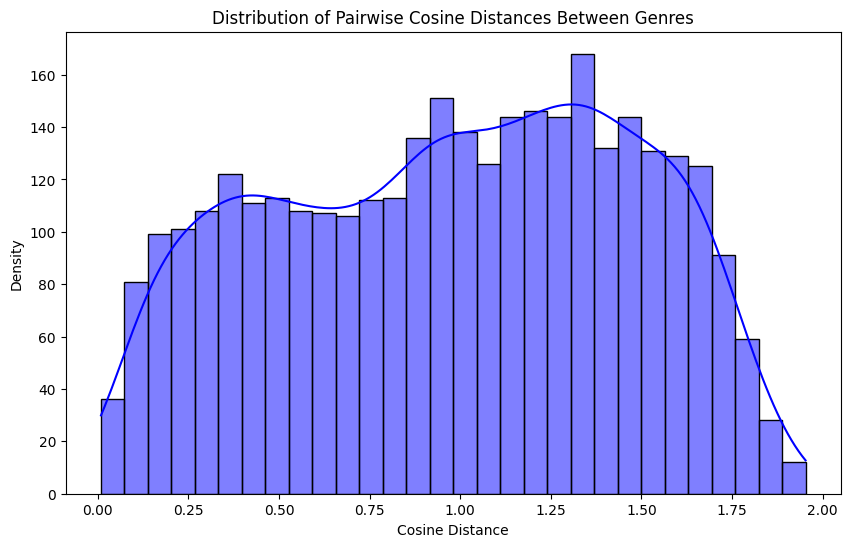

In [ ]:
# Pairwise cosine distance matrix between genres in the validation set
genre_list = sorted(set(y_val))
genre_embeddings = []
for genre in genre_list:
    genre_data = X_val_scaled[y_val == genre]
    if genre_data.size > 0:
        genre_centroid = pd.DataFrame(genre_data.mean(axis=0).reshape(1, -1), columns=columns_to_model)
        genre_embeddings.append(genre_centroid.values.flatten())
genre_embeddings = np.array(genre_embeddings)
genre_embeddings = genre_embeddings / np.linalg.norm(genre_embeddings, axis=1, keepdims=True)
# compute cosine distance matrix
cosine_dist_matrix = 1 - cosine_similarity(genre_embeddings)
# distribution of distances
distances = cosine_dist_matrix[np.triu_indices_from(cosine_dist_matrix, k=1)]
plt.figure(figsize=(10, 6))
sns.histplot(distances, bins=30, kde=True, color='blue')
plt.title("Distribution of Pairwise Cosine Distances Between Genres")
plt.xlabel("Cosine Distance")
plt.ylabel("Density")
plt.show()

We can see that a large number of genres are very similar to one another, which may present a problem when trying to model the distribution - clusters - of genres.

## Part 5.1 Agglomerative Hierarchical Clustering

We turn to Agglomerative Hierarchical Clustering (AHC) to gather an initial sense of the hierarchical structure of the genres in the data. AHC builds a hierarchy of clusters by iteratively merging the closest pairs of clusters based on a chosen distance metric and linkage criterion.

This could be particularly useful for our dataset, as it allows us to explore the data at different levels of granularity and identify natural groupings of genres, such as sub-genres within broader categories.

In [ ]:
agglomerative_clustering = AgglomerativeClustering(distance_threshold=0,
                                                   linkage="ward",
                                                   n_clusters=None,
                                                   compute_full_tree=True)
agglomerative_labels = agglomerative_clustering.fit_predict(X_train_subsampled)

To give meaningful names to the clusters produced by AHC, we can analyze the composition of each cluster in terms of the original genre labels. By examining the most common genres within each cluster, we can assign descriptive names that reflect the musical styles represented.

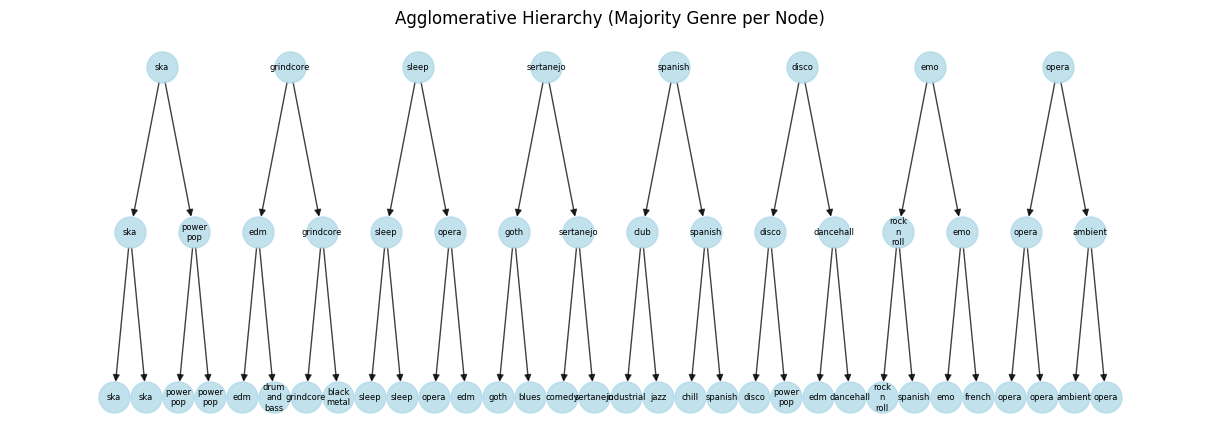

In [ ]:
n_leaves = agglomerative_clustering.n_leaves_
children = agglomerative_clustering.children_

node_majority = {}
node_counts = {}
for leaf in range(n_leaves):
    label = y_train_subsampled[leaf]
    node_majority[leaf] = label
    node_counts[leaf] = Counter([label])

for idx, (left, right) in enumerate(children):
    node_id = n_leaves + idx
    combined = node_counts[left] + node_counts[right]
    node_majority[node_id] = combined.most_common(1)[0][0]
    node_counts[node_id] = combined

tree = nx.DiGraph()
for idx, (left, right) in enumerate(children):
    parent = n_leaves + idx
    tree.add_edge(parent, left)
    tree.add_edge(parent, right)

def hierarchy_pos(G, root, width=1.0, vert_gap=0.2, vert_loc=0, xcenter=0.5, max_depth=None, curr_depth=0):
    children = list(G.successors(root))
    if not children or (max_depth is not None and curr_depth >= max_depth):
        return {root: (xcenter, vert_loc)}
    dx = width / max(len(children), 1)
    nextx = xcenter - width / 2 + dx / 2
    pos = {root: (xcenter, vert_loc)}
    for child in children:
        pos.update(hierarchy_pos(G, child, width=dx, vert_gap=vert_gap, vert_loc=vert_loc - vert_gap, xcenter=nextx, max_depth=max_depth, curr_depth=curr_depth + 1))
        nextx += dx
    return pos

root = max(tree.nodes)
min_depth = 3
max_depth = 5
positions = hierarchy_pos(tree, root, max_depth=max_depth)
# subtree with max depth 6 for clarity
subtree = tree.subgraph([n for n, pos in positions.items() if pos[1] >= positions[root][1] - max_depth * 0.2 and pos[1] <= positions[root][1] - min_depth * 0.2])

plt.figure(figsize=(12, 4))
nx.draw(subtree, pos=positions, with_labels=False, node_size=500, node_color="lightblue", alpha=0.75)
nx.draw_networkx_labels(subtree, positions, labels={node: node_majority[node].replace('-','\n') for node in subtree.nodes}, font_size=6)
plt.title("Agglomerative Hierarchy (Majority Genre per Node)")
plt.axis("off")
plt.show()

In the above visualization, we limit the depth of the tree to between the 3rd and 5th levels for clarity. However, this limitation, along with the fact that agglomerative clustering produces a strict hierarchy, means that some genres may be grouped together in unexpected ways, such as `rock-n-roll` and `opera`.

Accordingly, these results should be interpreted with caution, and perhaps used in conjunction with other clustering methods to gain a more comprehensive understanding of the data's structure.

Regardless, this structure provides some information as to the relations between genres, such as what overlaps we can expect given the data, when clustering with other algorithms, and thus how to fine-tune their hyper-parameters.

## Part 5.2 DBSCAN

We first turn to DBSCAN due to its flexibility in allowing outliers to not be assigned to clusters, and due to it being able to model non-convex clusters. Both of these properties are useful given the diversity of music genres in our dataset.

Moreover, DBSCAN does not require us to specify the number of clusters in advance, which is advantageous since we may not know the optimal number of genres beforehand, and in the previous part relied on heuristics that depend on prior modelling choices and assumptions. Instead, DBSCAN relies on two parameters: epsilon (the maximum distance between two samples for them to be considered as in the same neighborhood) and min_samples (the number of samples in a neighborhood for a point to be considered as a core point).

Since the complexity of DBSCAN is $O(n^2)$, we sample a smaller subset of the data (10,000 points) for efficiency. We also standardize the data to ensure that all features contribute equally to the distance calculations.

We perform a grid search over a range of epsilon and min_samples values to find the optimal parameters that yield the best clustering performance. We evaluate the clustering results using silhouette score, which measures how similar an object is to its own cluster compared to other clusters.

**epsilon**: This parameter defines the maximum distance between two samples for them to be considered as in the same neighborhood. A smaller epsilon value will result in more clusters, while a larger epsilon value will result in fewer clusters.

**min_samples**: This parameter specifies the minimum number of samples required to form a dense region (i.e., a cluster). A higher value for min_samples will result in fewer clusters, as more points are required to form a cluster.

In [ ]:
grid = {
    'eps': np.arange(1.0, 3.5, 0.25),
    'min_samples': np.arange(3, 100, 10),
    'metric': ["euclidean", "manhattan", "cosine"]
}
grid_results = {}
best_silhouette = -1
best_params = None
for eps in tqdm(grid['eps'], desc="Tuning eps"):
    for min_samples in tqdm(grid['min_samples'], desc="Tuning min_samples", leave=False):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X_train_subsampled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2: # need at least 2 clusters for silhouette score
            continue
        silhouette = metrics.silhouette_score(X_train_subsampled, labels)
        grid_results[(eps, min_samples)] = silhouette
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = (eps, min_samples)

Tuning eps:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

Tuning min_samples:   0%|          | 0/10 [00:00<?, ?it/s]

We visualize the silhouette scores for different combinations of epsilon and min_samples. The heatmap shows that certain parameter combinations yield higher silhouette scores, indicating better-defined clusters.

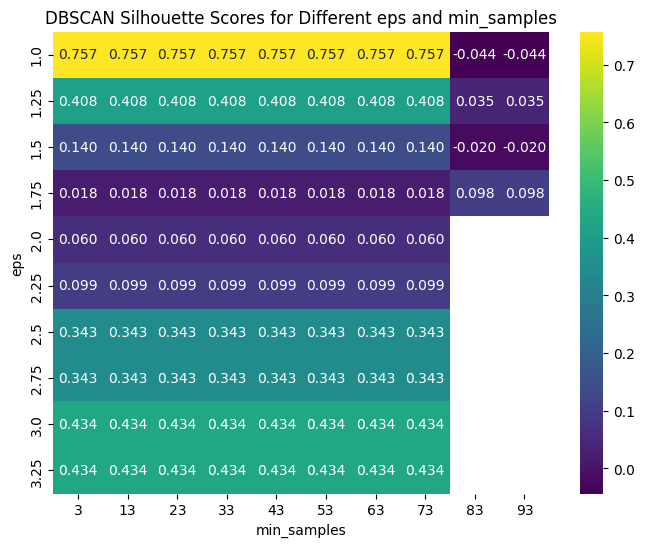

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
silhouette_matrix = np.full((len(grid['eps']), len(grid['min_samples'])), np.nan)
for (eps, min_samples), silhouette in grid_results.items():
    i = np.where(grid['eps'] == eps)[0][0]
    j = np.where(grid['min_samples'] == min_samples)[0][0]
    silhouette_matrix[i, j] = silhouette
sns.heatmap(silhouette_matrix, annot=True, fmt=".3f",
            xticklabels=grid['min_samples'], yticklabels=grid['eps'],
            cmap='viridis', ax=ax)
ax.set_xlabel("min_samples")
ax.set_ylabel("eps")
ax.set_title("DBSCAN Silhouette Scores for Different eps and min_samples");

Since the silhouette scores are generally poor across the grid search, we next try to optimize the DBSCAN parameters directly using Bayesian optimization. This approach allows us to efficiently explore the parameter space and find the optimal epsilon and min_samples values that maximize the silhouette score.

Best DBSCAN params: eps=0.37111037397092816, min_samples=31 with silhouette=1.000



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


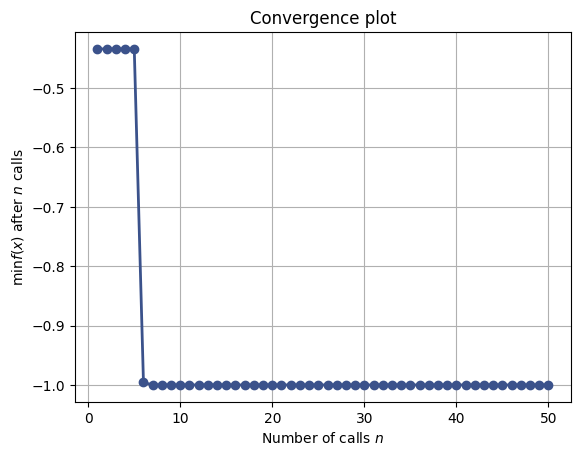

In [ ]:
# Bayesian optimization of hyperparameters
warnings.filterwarnings("ignore", category=UserWarning)

def dbscan_neg_silhouette(params):
    eps, min_samples = params
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
    labels = dbscan.fit_predict(X_train_subsampled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters < 2:
        return 1.0  # return a high negative silhouette score
    silhouette = metrics.silhouette_score(X_train_subsampled, labels)
    return -silhouette  # we minimize negative silhouette

search_space = [
    Real(0.25, 5.0, name='eps'),
    Integer(3, 50, name='min_samples')
]
result = gp_minimize(dbscan_neg_silhouette, search_space, n_calls=50, random_state=seed, )
best_eps, best_min_samples = result.x
best_silhouette = -result.fun

print(f"Best DBSCAN params: eps={best_eps}, min_samples={best_min_samples} with silhouette={best_silhouette:.3f}\n")
plot_convergence(result)
warnings.resetwarnings()

In [ ]:
# assign cluster labels to the full training set
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples, n_jobs=-1)
dbscan_final.fit(X_train_subsampled)
train_labels = dbscan_final.labels_

clustered_df = pd.DataFrame({
    'true_genre': y_train_subsampled,
    'predicted_cluster': train_labels
})
clustered_df['cluster_size'] = clustered_df.groupby('predicted_cluster')['predicted_cluster'].transform('count')

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
clustered_df.describe().iloc[:3, 1]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,cluster_size
count,9922.0
mean,82.0
std,0.0


As we can see in the above, despite optimizing the parameters for silhouette score, which would optimize clusters to maximize between-cluster distance, and minimize inner-cluster distance, we have all clusters of exactly equal size - 82 data points, and thus far from modelling the genre distribution.

This suggests that DBSCAN, with the given features, is unable to find a solution that resembles the genre structure in the data.

## Part 5.2 KMeans

We turn next to K-Means, to make use of the information we have regarding the number of genres in the data, which should inform the hyper-parameter search. We find the (approximate) optimal K-number of clusters by iterating over all possible values of K (from 1 cluster through # of genres). For efficiency, in actuality we estimate every 3rd value.
Additionally, we model both the raw (original) data and scaled data.

In [ ]:
fit_kmeans = lambda k: KMeans(n_clusters=k, init='k-means++', random_state=seed).fit(X_train)
fit_kmeans_scaled = lambda k: KMeans(n_clusters=k, init='k-means++', random_state=seed).fit(X_train_scaled)

results = {}
for fit_type, fit_func in zip(['Raw', 'Scaled'], [fit_kmeans, fit_kmeans_scaled]):
    inertias = []
    homogeneity_scores = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        futures = []
        for k in range(1, n_genres+1, 3):
          futures.append(executor.submit(fit_func, k))

        for future in tqdm(futures, total=len(futures), leave=False):
            try:
              result_model = future.result()
              if fit_type == 'Raw':
                  y_pred = result_model.predict(X_val)
                  y_s = y_val
              else:
                  y_pred = result_model.predict(X_val_scaled)
                  y_s = y_val

              hscore = metrics.homogeneity_score(y_s, y_pred)
              homogeneity_scores.append(hscore)
              inertias.append(result_model.inertia_)

            except Exception as e:
              print(f"Failed: {e}")
    results[fit_type] = {
        'inertias': inertias,
        'homogeneity_scores': homogeneity_scores
    }

We estimate both the inertia of the models, and the homogeneity (the measure of how unique each genre is to each cluster).

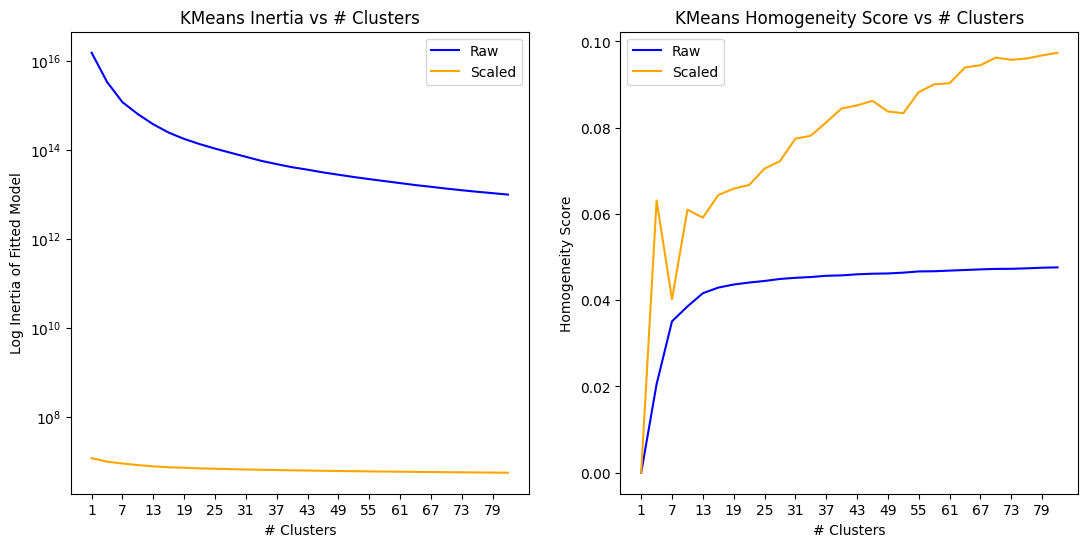

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

for color, (result_type, result) in zip(['blue', 'orange'], results.items()):
    inertias = result['inertias']
    homogeneity_scores = result['homogeneity_scores']
    ax1.plot(inertias, color=color, label=result_type)
    ax1.set_xticks(range(0, len(inertias), 2), range(1, n_genres+1, 6))
    ax1.set_xlabel("# Clusters")
    ax1.set_ylabel("Log Inertia of Fitted Model")
    ax1.set_yscale("log")

    ax2.plot(homogeneity_scores, color=color, label=result_type)
    ax2.set_xticks(range(0, len(homogeneity_scores), 2), range(1, n_genres+1, 6))
    ax2.set_xlabel("# Clusters")
    ax2.set_ylabel("Homogeneity Score");
ax1.set_title("KMeans Inertia vs # Clusters")
ax2.set_title("KMeans Homogeneity Score vs # Clusters")
ax1.legend()
ax2.legend()
plt.show()

Without scaling, both homogeneity and inertia reach a limit at around 7 clusters. However, with scaling, modeling the data with significantly more clusters (we choose 30) is still useful, suggesting that the scaled data improves the separability of the genres.

In [ ]:
K = 30 # approximated through the elbow method

We next estimate the _marginal_ homogeneity degradation of each genre, by fitting a leave-one-out model for each genre. This approximates how much each genre detracts from the separability of the genres in the data, however it requires several assumptions, primarily invariance to permutation.

In [ ]:
genres = sorted(set(spotify_df.genre.unique().tolist()))
model_template = KMeans(n_clusters=K, init='k-means++', random_state=seed)

baseline = clone(model_template).fit(X_train_scaled)
baseline_hscore = metrics.homogeneity_score(y_val, baseline.predict(X_val_scaled))

def leave_one_out_homogeneity(g):
  mask_train = y_train != g
  mask_val = y_val != g
  if not mask_train.any() or not mask_val.any():
    return g, None
  model = clone(model_template).fit(X_train_scaled[mask_train])
  y_pred = model.predict(X_val_scaled[mask_val])
  hscore = metrics.homogeneity_score(y_val[mask_val], y_pred)
  return g, hscore

results = []
with ThreadPoolExecutor(max_workers=8) as executor:
  futures = {executor.submit(leave_one_out_homogeneity, g): g for g in genres}
  for future in tqdm(as_completed(futures), total=len(futures), leave=False):
    genre, h = future.result()
    if h is None:
      continue
    results.append((genre, h, baseline_hscore - h))

results.sort(key=lambda x: x[2], reverse=True)

ordered_genres, hscores, marginal_deltas = zip(*results)

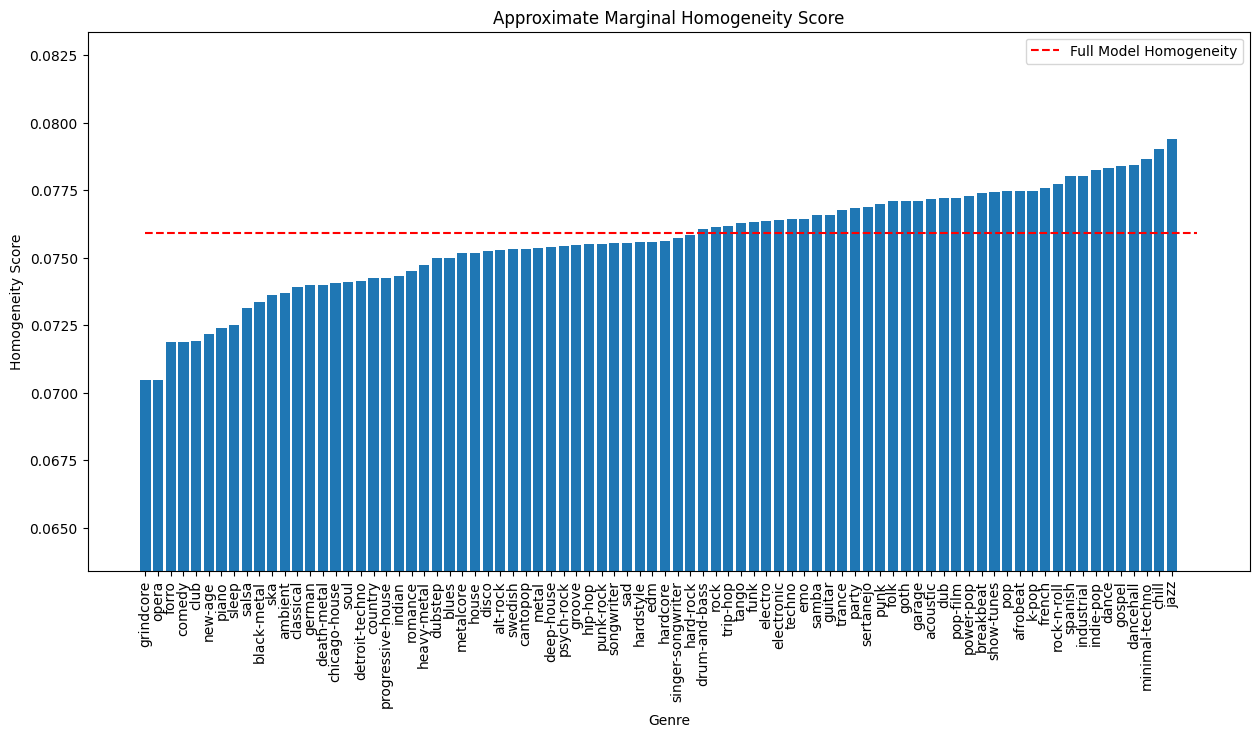

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(hscores)), hscores)
ax.hlines(baseline_hscore, xmin=0, xmax=len(hscores)+1, color='red', linestyle='--', label="Full Model Homogeneity")
ax.set_xticks(ticks=list(range(len(hscores))), labels=ordered_genres, rotation=90)
ax.set_title("Approximate Marginal Homogeneity Score")
ax.set_ylabel("Homogeneity Score")
ax.set_xlabel("Genre")
ax.legend()
ylim_min = min(hscores) * 0.9
ax.set_ylim(bottom=ylim_min);

We can see that genres such as `blues`, `spanish` and `club` contribute the most to the inseparability of the data, however overall the differences are not large between genres.

Next, we plot the clusters in the data after reducing it to 2 dimensions. To do so, we use PCA to produce the principal components with the highest variance.
On top of each subplot, we also plot the loading of each feature in the data, indicating the directions in the new embedding space that are correlated with increase in that feature value.

Left: the test data, colored by cluster ID. Red Xs signify cluster centroids.

Right: centroids of each genre, in the same embedding space.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


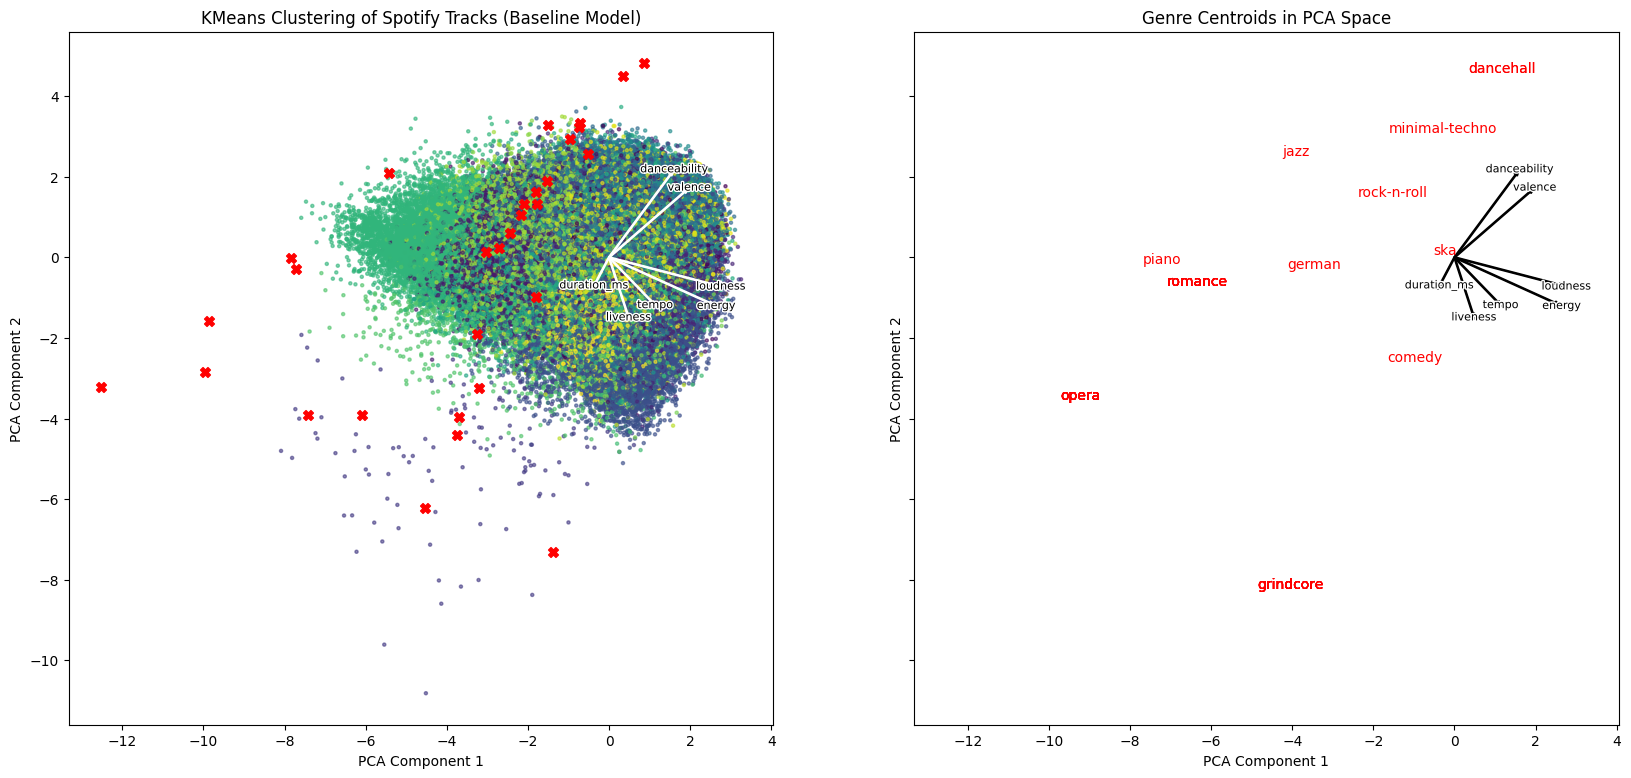

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# Scatter plot of the clusters with baseline model
baseline_labels = baseline.predict(X_val_scaled)

pca = PCA(n_components=2)

principal_components = pca.fit_transform(X_val_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

X_val_pca = pca.fit_transform(X_val_scaled)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), sharex=True, sharey=True)

# plot of PCA-reduced test data
scatter = ax1.scatter(X_val_pca[:, 0], X_val_pca[:, 1], c=baseline_labels, cmap='viridis', alpha=0.6, s=5)
for i, feature in enumerate(columns_to_model):
    if feature.startswith("embed"): # The values of the features of the track name embedding are uninterpretable
        continue
    ax1.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, color='white', alpha=1.0, head_width=0.1, width=0.03)
    ax1.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature,
             color='black',
             ha='center', va='center',
             fontsize=8,
             path_effects=[patheffects.Stroke(linewidth=2, foreground='white'), patheffects.Normal()])
ax1.set_title('KMeans Clustering of Spotify Tracks (Baseline Model)')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

# Get cluster centroids in PCA space
centroids = scaler.transform(baseline.cluster_centers_)
centroids_pca = pca.transform(centroids)

# Get genre centroids in PCA space
genre_centroids = []
for genre in genres:
    genre_data = X_train_scaled[y_train == genre]
    if genre_data.size > 0:
        genre_centroid = pd.DataFrame(genre_data.mean(axis=0).reshape(1, -1), columns=columns_to_model)
        genre_centroids.append((genre, genre_centroid))


ax1.scatter(centroids_pca[:, 0], centroids_pca[:, 1], c='red', marker='X', s=50, label='Centroids')

# only show 1-nearest genre per centroid
genres_matrix = np.array([gc[1].values.flatten() for gc in genre_centroids])
for i, centroid in enumerate(centroids):
    distances = np.linalg.norm(genres_matrix - centroid, axis=1)
    nearest_index = np.argmin(distances)
    genre_centroids[i] = (genre_centroids[nearest_index][0], genre_centroids[nearest_index][1])

# further subsample genres based on L2 norm
sampling_prob = np.array([np.linalg.norm(gc[1].values.flatten()) for gc in genre_centroids])
sampling_prob /= sampling_prob.sum()
sampled_genres = np.random.choice([gc[0] for gc in genre_centroids], size=15, replace=False, p=sampling_prob)
genre_centroids = [gc for gc in genre_centroids if gc[0] in sampled_genres]

for genre, centroid in genre_centroids:
    centroid_scaled = scaler.transform(centroid)
    centroid_pca = pca.transform(centroid_scaled)
    ax2.scatter(centroid_pca[0, 0], centroid_pca[0, 1], marker='', s=20, label=genre)
    ax2.text(centroid_pca[0, 0], centroid_pca[0, 1], genre, color='red')

for i, feature in enumerate(columns_to_model):
    if feature.startswith("embed"): # The values of the features of the track name embedding are uninterpretable
      continue
    ax2.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, color='black', alpha=1.0, head_width=0.1, width=0.03)
    ax2.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature,
             color='black',
             ha='center', va='center',
             fontsize=8,
             path_effects=[patheffects.Stroke(linewidth=2, foreground='white'), patheffects.Normal()])



ax2.set_title('Genre Centroids in PCA Space')
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')

plt.show()

We can see that, while we chose the number of clusters K based on evaluation of two metrics in priors steps, some of the clusters appear redundant on the PCA plot. While this may be a result of the PCA plot losing relevant information about the data, it does warrant further fine-tuning of the modelling choices.

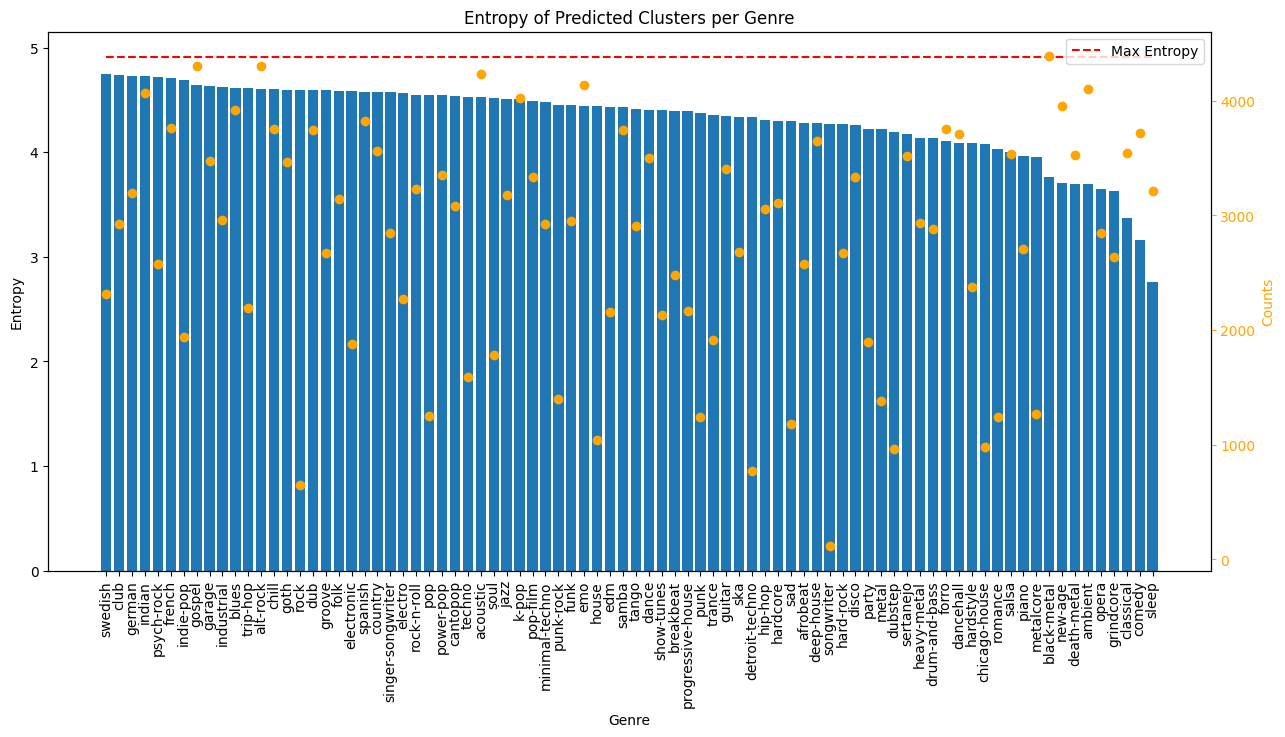

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:

pred_df = pd.DataFrame({
    'true_genre': y_val,
    'predicted_cluster': baseline_labels
})

# entropy of each genre
genre_entropy = {}
for genre in genres:
    genre_preds = pred_df[pred_df['true_genre'] == genre]['predicted_cluster']
    counts = Counter(genre_preds)
    total = sum(counts.values())
    probs = [count / total for count in counts.values()]
    entropy = -sum(p * np.log2(p) for p in probs if p > 0)
    genre_entropy[genre] = entropy

# plot entropy values
fig, ax = plt.subplots(figsize=(15, 7))
ordered_genres = sorted(genre_entropy.keys(), key=lambda g: genre_entropy[g], reverse=True)
entropy_values = [genre_entropy[g] for g in ordered_genres]
max_entropy = np.log2(K)
ax.bar(range(len(entropy_values)), entropy_values)
ax.hlines(max_entropy, xmin=0, xmax=len(entropy_values)-1, color='red', linestyle='--', label='Max Entropy')
ax.set_xticks(ticks=list(range(len(entropy_values))), labels=ordered_genres, rotation=90)
ax.set_title("Entropy of Predicted Clusters per Genre")
ax.set_ylabel("Entropy")
ax.set_xlabel("Genre")

# plot genre counts
ax2 = ax.twinx()
genre_counts = [pred_df[pred_df['true_genre'] == g].shape[0] for g in ordered_genres]
ax2.plot(range(len(genre_counts)), genre_counts, color='orange', marker='o', label='Genre Counts', linestyle='')
ax2.set_ylabel("Counts")
ax2.yaxis.label.set_color('orange')
ax2.tick_params(axis='y', colors='orange')

ax.legend();

In [ ]:

genre_counts_arr = np.array(genre_counts)
entropy_arr = np.array(entropy_values)
pearson_corr, pearson_p = pearsonr(genre_counts_arr, entropy_arr)

print(f"Pearson r = {pearson_corr:.3f}, p = {pearson_p:.3g}")

Pearson r = -0.065, p = 0.563


Finally, we plot here the entropy of cluster distribution for each genre: the lower entropy is, the more unique a genre is to a given cluster, and vice versa. This is closely related to homogeneity, however it gives us some indication of which genres are more similar to all other genres (and are harder to separate), providing a notion of hierarchy of "generality" or "commonality" of music genres.
We can see that `grindcore` and `minimal-techno` for example induce highly specialized clusters, while `indian`, `psych-rock` and `german` are much more difficult to separate from other genres.

We can also rule out that this is an effect of the frequency of genres in the data (orange dots), since there is no obvious trend with respect to entropy (specifically, low Pearson correlation with no statistical significance).

We note that these results are dependent not only on the data, but also the model choice (including hyper-parameters), and thus any drawn conclusions are also dependent on both.

KMeans, despite being the simplest method of the three models we tested, has shown to provide the clearest separation of genres into distinct clusters. However, this separation is far from ideal, and is greatly affected by the similarity of genres and the fine-grained nature of their allocation. This is supported by the initial evidence of distribution of distances between genres.

# Part 6: Results

As discussed in the modelling section, we experimented with multiple clustering algorithms to group the songs in our dataset based on their audio features and track name embeddings. Below, we summarize the key findings from each method and evaluate their effectiveness in capturing meaningful genre-based clusters.
## DBSCAN Results
DBSCAN struggled to produce meaningful clusters in our dataset. Despite extensive hyperparameter tuning using both grid search and Bayesian optimization, the resulting clusters were of equal size and did not reflect the underlying genre structure. The silhouette scores were generally poor, indicating that DBSCAN was unable to find well-defined clusters given the feature set. This suggests that DBSCAN may not be suitable for this type of data, possibly due to its sensitivity to parameter choices and the high dimensionality of the feature space.
## K-Means Results
K-Means performed better than DBSCAN, allowing us to leverage our knowledge of the number of genres in the dataset. By varying the number of clusters and evaluating metrics such as inertia and homogeneity, we found that scaling the data significantly improved genre separability. The optimal number of clusters appeared to be around 30 when using scaled features. However, some clusters still appeared redundant in PCA visualizations, indicating that further fine-tuning is necessary. The entropy analysis revealed that certain genres were more challenging to separate, suggesting a hierarchy of genre commonality. Overall, while K-Means showed promise, it did not fully capture the ideal genre separation, indicating that more sophisticated methods may be needed.

# Part 7: Conclusion and Discussion

In this project, we conducted an extensive exploratory data analysis and applied various clustering algorithms to group songs based on their audio features and track name embeddings. Our findings highlighted the challenges of clustering in high-dimensional spaces and the limitations of certain algorithms like DBSCAN for this type of data. K-Means showed more promise, especially when the data was properly scaled, but still fell short of perfectly capturing genre distinctions.

We found that model performance was most improved by careful feature engineering, particularly the transformation of quasi-binary features into categorical bins and the inclusion of track name embeddings. These steps helped to reduce noise and emphasize meaningful patterns in the data. However, challenges remain in fully capturing the nuanced relationships between genres, suggesting that further refinement of both features and modeling techniques is necessary for optimal clustering outcomes.
Furthermore, the embeddings we generated for text features may be improved and be more informative given a more robust, complex embedding model than the one we use. These embeddings also detract from the interpretability of the models, in producing dense embeddings that have no feature-semantics attached to them (contrast with manually engineered features such as `loudness`).

The limitations of the models we explored stem from their assumptions about cluster shapes and distributions. DBSCAN's reliance on density-based clustering made it sensitive to parameter choices and less effective in high-dimensional spaces. K-Means, while more flexible, assumes spherical clusters of similar sizes, which may not align with the true structure of musical genres. Additionally, both methods struggled with the inherent complexity and overlap between genres, indicating that more sophisticated approaches may be required to fully capture the rich diversity of music styles present in the dataset.

Future work could explore advanced clustering techniques such as hierarchical clustering, Gaussian mixture models, or deep learning-based approaches to better capture the complex relationships in the data. Additionally, incorporating more domain-specific features or leveraging external metadata might improve clustering performance and genre interpretability. Furthermore, a deeper investigation into the temporal dynamics of popularity and its influence on genre clustering could provide valuable insights for future analyses.